TODO: 
- Allow choice of simulator and choice betweeen Runtime or Aer
- Add resilience_level as argument      
- Change PauliSet with PauliList
- use statevector for vqe instead of qasm

In [6]:
from qiskit_nature.drivers import Molecule
from qiskit_nature.drivers.second_quantization import (
    ElectronicStructureMoleculeDriver, ElectronicStructureDriverType)
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.transformers.second_quantization.electronic import FreezeCoreTransformer
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import ParityMapper
from qiskit.opflow import TwoQubitReduction
from qiskit.utils import QuantumInstance
from qiskit import IBMQ, BasicAer, Aer
from qiskit.algorithms.optimizers import COBYLA
from qiskit_nature.algorithms import (GroundStateEigensolver,
                                      NumPyMinimumEigensolverFactory)
from qiskit_nature.circuit.library import UCCSD, HartreeFock
from qiskit.algorithms import VQE



def exact_solver(problem, converter):
    solver = NumPyMinimumEigensolverFactory()
    calc = GroundStateEigensolver(converter, solver)
    result = calc.solve(problem)
    return result

def get_qubit_op(coordinates):
    
    # Define Molecule
    molecule = Molecule(
        # Coordinates in Angstrom
        geometry=[
            ["H", [coordinates[0],coordinates[1],0]],
            ["H", [coordinates[2],coordinates[3],0]],
            ["H", [coordinates[4],coordinates[5],0]]
        ],
        multiplicity=1,  # = 2*spin + 1
        charge=1,
    )

    driver = ElectronicStructureMoleculeDriver(
        molecule=molecule,
        basis="sto3g",
        driver_type=ElectronicStructureDriverType.PYSCF)

    # Get properties
    properties = driver.run()
    num_particles = (properties
                        .get_property("ParticleNumber")
                        .num_particles)
    num_spin_orbitals = int(properties
                            .get_property("ParticleNumber")
                            .num_spin_orbitals)
    
    # Define Problem, Use freeze core approximation, remove orbitals.
    problem = ElectronicStructureProblem(
        driver,
        [FreezeCoreTransformer(freeze_core=True)])

    second_q_ops = problem.second_q_ops()  # Get 2nd Quant OP
    num_spin_orbitals = problem.num_spin_orbitals
    num_particles = problem.num_particles

    mapper = ParityMapper()  # Set Mapper
    hamiltonian = second_q_ops[0]  # Set Hamiltonian
    # Do two qubit reduction
    converter = QubitConverter(mapper,two_qubit_reduction=True)
    reducer = TwoQubitReduction(num_particles)
    qubit_op = converter.convert(hamiltonian)
    qubit_op = reducer.convert(qubit_op)

    return qubit_op, num_particles, num_spin_orbitals, problem, converter

def calc_ground_state(op,num_part,num_orb,problem,converter,simulator='qasm', shots=1028):

    
    if simulator == 'qasm':
        backend = Aer.get_backend('qasm_simulator') 
        quantum_instance = QuantumInstance(backend,shots=shots)
        optimizer = COBYLA(maxiter=400)
    elif simulator == 'exact':
        backend = BasicAer.get_backend("statevector_simulator")
        quantum_instance = QuantumInstance(backend)
        optimizer = COBYLA(maxiter=400)
    else:
        print('Error: simulator should be qasm or exact!')
 
    result = exact_solver(problem,converter)
    
    ### 
    backend = BasicAer.get_backend("statevector_simulator")
    quantum_instance = QuantumInstance(backend)
    optimizer = COBYLA(maxiter=400)
    ###
    
    init_state = HartreeFock(num_orb, num_part, converter)
     
    var_form = UCCSD(converter,
                        num_part,
                        num_orb,
                        initial_state=init_state)

    vqe = VQE(var_form, optimizer, quantum_instance=quantum_instance) 
    vqe_result = vqe.compute_minimum_eigenvalue(op)
    min_eng = vqe_result.eigenvalue
    final_params = vqe_result.optimal_parameters 
    vqe_ground = vqe.ansatz.bind_parameters(final_params)  
    
    print('ground state energy: ',min_eng)
    
    return vqe_ground, min_eng

In [7]:
#from qiskit_ibm_runtime import QiskitRuntimeService, Session, Options, Sampler, Estimator
#QiskitRuntimeService.save_account(channel='ibm_quantum', token='252ba5e147b539584abe2c3d2e57092aa66d115a75af64498c8d9b35746cc59b0ffc1e21a78d7e0089829f19a7b12ed2e9da2c75504854ee967e07331bb5b709', overwrite=True)
#service = QiskitRuntimeService(channel='ibm_quantum')

In [8]:
Ha = 4.36e-18
angst = 1.0e-10
dR = 0.02 #removed the angst, since coordinates are given in angst
m = 16 #times which we calculate the force

from qiskit.opflow import I, X, Y, Z
from qiskit.opflow.primitive_ops import PauliOp, PauliSumOp
from qiskit.quantum_info import Pauli
#from hamiltonian import calc_ground_state, get_qubit_op
import numpy as np
from qiskit.utils import QuantumInstance
from qiskit.opflow import PauliExpectation, CircuitSampler, StateFn, CircuitStateFn
from qiskit import IBMQ, BasicAer, Aer

import multiprocessing as mp
from joblib import Parallel, delayed

num_cores = mp.cpu_count()


import time #to see which part of code takes the longest


def get_psi_0(coordinates, simulator='qasm',shots=1028):

    #get qubit operator corresponding to H(R)
    (qubit_op, num_part, num_orb, problem, converter) = get_qubit_op(coordinates)
    #get the ground state of H(R)
    psi_0,_ = calc_ground_state(qubit_op,num_part, num_orb, problem, converter, simulator,shots=shots)
    psi_0 = CircuitStateFn(psi_0)

    return psi_0

def calc_forces(coordinates, psi=None, simulator='qasm'):
    
    psi_0 = psi
    
    if (psi_0 == None):
        psi_0 = get_psi_0(coordinates, simulator)
        
    if simulator == 'exact':
        backend = Aer.get_backend('qasm_simulator') 
        q_instance = QuantumInstance(backend, shots=1028)
    elif simulator == "exact":
        backend = BasicAer.get_backend("statevector_simulator")
        q_instance = QuantumInstance(backend)
    else:
        print('Error: simulator should be qasm or exact!')
        
    forces = []
    vars = []
    #loop over particles
    
    for i in range(len(coordinates)):

        #get qubit operators coresponding to H+ (hamiltonian for atomic distances R + dR)
        (qubit_op_plus, num_part_plus, num_orb_plus, problem_plus, converter_plus) = get_qubit_op(np.split((coordinates[0:i]+[(coordinates[i]+dR)]+coordinates[i+1:]),3))
    
        #get qubit operators coresponding to H- (hamiltonian for atomic distances R - dR)
        (qubit_op_minus, num_part_minus, num_orb_minus, problem_minus, converter_minus) = get_qubit_op(np.split((coordinates[0:i]+[(coordinates[i]+dR)]+coordinates[i+1:]),3))
    
        rep_eng_plus = problem_plus.grouped_property_transformed.get_property("ElectronicEnergy").nuclear_repulsion_energy
        rep_eng_minus = problem_minus.grouped_property_transformed.get_property("ElectronicEnergy").nuclear_repulsion_energy
    
        #define desired observable (H_+ - H_-)/(2dR) = force  
        Obs = (qubit_op_plus-qubit_op_minus)
        Obs_var = Obs*Obs
        print("PRIMITIVE LIST")
        print(Obs_var.primitive.to_list())
        nuc = rep_eng_plus - rep_eng_minus
        #Obs_squared = Obs * Obs
       
        #get the expectation value <psi_0|O|psi_0>Ã‚Â¨
        
        measurable_expression = StateFn(Obs, is_measurement=True).compose(psi_0)
        measurable_expression_var = StateFn(Obs_var, is_measurement=True).compose(psi_0)
        #measurable_expression_var =  StateFn(Obs_squared, is_measurement=True).compose(psi_0)
        expectation = PauliExpectation().convert(measurable_expression)
        expectation_var = PauliExpectation().convert(measurable_expression_var)
 
        #expectation_var = PauliExpectation().convert(measurable_expression)
        sampler = CircuitSampler(q_instance).convert(expectation)
        sampler_var = CircuitSampler(q_instance).convert(expectation_var)
        #sampler_var = CircuitSampler(q_instance).convert(expectation) 

        f = sampler.eval().real + nuc
        ff = sampler_var.eval().real + 2*sampler.eval().real*nuc +nuc**2 +(sampler.eval().real)**2
        print(ff)
        #print(sampler_var.eval())
        #variance = sampler_var.eval().real - f^2
        forces.append(f*Ha*(1/(2*dR*angst)))
        vars.append(ff*Ha*(1/(2*dR*angst)))
        # in the dimension of nN to avoid small values.
    
    return forces,vars


def calc_force_and_cov(coordinates, simulator = 'qasm', PauliSet = None, mode = 'full', shots = 1028):
    
    
    
    if simulator == 'exact':
            backend = Aer.get_backend('qasm_simulator') 
            q_instance = QuantumInstance(backend, shots=shots)
    elif simulator == "qasm":
            backend = BasicAer.get_backend("statevector_simulator")
            q_instance = QuantumInstance(backend)
    else:
        print('Error: simulator should be qasm or exact!')
       
    
    '''
    ### TODO: rewrite code so that it allows choice of backend, also whether to use Aer or Runtime ###
    backend = service.backends(simulator=True)[0]
    '''
    
    num_coord = len(coordinates)   
    
    start = time.time()
    psi_0 = get_psi_0(coordinates, simulator = simulator, shots=shots)
    end = time.time()
    
    time_psi_0 = end - start

    forces = np.zeros(num_coord)
    force_ops = []
    force_op_coeffs = [] # array with dictionaries containing Pauli coefficients
    coordinates = coordinates.tolist()
    
    
    start = time.time()
    #get force component operators and decomposition (without the 1/(2*dR) factor, for numerical reasons) 
    for i in range(num_coord):
        
        #get qubit operators coresponding to H+ (hamiltonian for atomic distances R + dR)
        (qubit_op_plus, num_part_plus, num_orb_plus, problem_plus, converter_plus) = get_qubit_op(coordinates[0:i]+[(coordinates[i]+dR)]+coordinates[i+1:])
        #get qubit operators coresponding to H- (hamiltonian for atomic distances R - dR)
        (qubit_op_minus, num_part_minus, num_orb_minus, problem_minus, converter_minus) = get_qubit_op(coordinates[0:i]+[(coordinates[i]-dR)]+coordinates[i+1:])

        rep_eng_plus = problem_plus.grouped_property_transformed.get_property("ElectronicEnergy").nuclear_repulsion_energy
        rep_eng_minus  = problem_minus.grouped_property_transformed.get_property("ElectronicEnergy").nuclear_repulsion_energy
        
        qubit_op_plus = qubit_op_plus + rep_eng_plus*(I^I^I^I) #TODO:number of I's needs to be changed according to number of qubits
        qubit_op_minus = qubit_op_minus + rep_eng_minus*(I^I^I^I)
        
       
        op =  -(qubit_op_plus - qubit_op_minus).reduce()
                    
        op_list = op.primitive.to_list() #list containing Pauli operators in support and corresponding coeffs
        
        #construct dict from list
        op_dict = {}
        for (PauliString,coeff) in op_list:

            if PauliString in op_dict:
                op_dict[PauliString] += coeff
            else:
                op_dict[PauliString] = coeff
                
        force_ops.append(op)
        force_op_coeffs.append(op_dict)
        
        if i == 0:  #we need two Pauli Ops to calculate the product and their support
            P1 = op
    
    
    if PauliSet == None:
        
        pauli_op_set = {'IIII'} #Could not initialize empty set for some reason
        # construct set of PauliOp products that we need to calculate

        for PauliString,coeff in force_op_coeffs[0].items():
            pauli_op_set.add(PauliString)

        #to get set of necessary PauliOp products: 
        P_prod = P1@P1
        P_list = P_prod.primitive.to_list()

        for (PauliString,coeff) in P_list:
            pauli_op_set.add(PauliString)
                
    else: pauli_op_set = PauliSet
        
    end = time.time()
    
    time_pauli_ops = end - start
        

        # Now we calculate the expectation values of all the relevant PauliOps
    
    
    exp_dict = {} # dictionary with relevant expectation values
    
    start = time.time()
     
    for pauli_string in pauli_op_set:
        Obs = PauliOp(Pauli(pauli_string))  
        measurable_expression = StateFn(Obs, is_measurement=True).compose(psi_0)
        expectation = PauliExpectation().convert(measurable_expression)  
        sampler = CircuitSampler(q_instance).convert(expectation) 
        E = sampler.eval().real     
        exp_dict[pauli_string] = E

    '''
    #Note: have taken this out of time estimate!!
    pauli_string_list = list(pauli_op_set)
    pauli_op_list = [PauliSumOp.from_list([(pauli_string,1.0)]) for pauli_string in pauli_string_list]
    
    
    
    #runtime code - way to slow
    with Session(service=service,backend=backend):
        estimator = Estimator()
        job = estimator.run(circuits=[psi_0]*len(pauli_op_list), observables=pauli_op_list,shots=shots)
        
    exp_values = job.result().values
    
    for (i,pauli_string) in enumerate(pauli_string_list):
        exp_dict[pauli_string] = exp_values[i]
    '''
                   
    for i in range(len(coordinates)):
        for pauli_op,coeff in force_op_coeffs[i].items():
            forces[i] += coeff.real*exp_dict[pauli_op]
            
    end = time.time()   
    time_calc_exp = end - start
    
    
    start = time.time()
    COV = np.zeros((num_coord,num_coord)) #force covariance matrix, without some multiplicative factors. 
        
    for i in range(num_coord):
        for j in range(i,num_coord):
            Pij = force_ops[i]@force_ops[j]
            Pij = Pij.reduce()
            Pij_list = Pij.primitive.to_list()

            #add product expectation <FiFj>
            for (pauli_string,coeff) in Pij_list:
                COV[i,j] += coeff.real*exp_dict[pauli_string]
                    #subtract <Fi><Fj>
            COV[i,j] -= forces[i]*forces[j]

            #since COV is symmetric
            if i < j:
                COV[j,i] = COV[i,j]
    end = time.time()
    
    time_cov = end - start

    print(f'Time to: Calculate Ground State - {round(time_psi_0,2)}s, Get Pauli Ops - {round(time_pauli_ops,2)}s, Calculate Pauli Expectation Values - {round(time_calc_exp,2)}s, Calculate Covariance - {round(time_cov,2)}s')
    #print(COV)
    return forces*Ha*(1/(2*dR*angst)),1/shots*COV*(Ha*(1/(2*dR*angst)))**2

In [13]:
#from Quantech.verlet_integrator import distance
#from force import calc_force_and_cov
import numpy as np
from tqdm import tqdm #to show progress


#implementation of the explicit Euler integrator
femto = 1.0e-15
angst = 1.0e-10

def distance(coordinates1,coordinates2):
    return np.sqrt(np.power((coordinates1[0] - coordinates2[0]),2) + np.power((coordinates1[1] - coordinates2[1]),2))


def main():
    #mass of particle1 (H)
    mass_0 = 1.67e-27
    #mass of particle2 (H)
    mass_1 = 1.67e-27
    #mass of particle3 (H)
    mass_2 = 1.67e-27
    #time step of integrator
    dt = 0.2*femto
    #initial velocity of atoms
    v_init_0 = np.array([0,0])
    v_init_1 = np.array([0,0])
    v_init_2 = np.array([0,0])

    v_init = np.concatenate((v_init_0,v_init_1,v_init_2),axis=None)

    #distances between atoms
    d = 0.8

    #initial positions of atoms, arrangement = equilateral triangle
    init_pos0 = np.array([0,0])
    init_pos1 = np.array([d,0])
    init_pos2 = np.array([d/2,np.sqrt(3)/2*d])
    init_pos = np.concatenate((init_pos0,init_pos1,init_pos2),axis=None)

    #integrator timesteps
    times = np.arange(0*femto, 60.0*femto, dt)
    #coordinate array
    coords = [init_pos]
    force = []
    distance01 = [d]
    distance02 = [d]
    distance12 = [d]
    #temperature in ?? 
    #k_B*T in Joule
    k_b = 1.38065e-23
    T = 420
    k_T = k_b*T
        #delta factor
    delta = 8.0*dt
    #hold v_next
    v_next = None
    
    simulator = 'qasm'

    for time in tqdm(times, desc='Progress: '):
        
        r = coords[-1]
        
        (forces,COV) = calc_force_and_cov(coords[-1],simulator = simulator, shots = 10)
        
        if time == 0:

            v_next = v_init - delta/(2*k_T*np.power(mass_0*mass_1*mass_2,1/3))*np.matmul(COV,v_init)*dt + dt*forces/mass_0
            
            r_next = (r*angst + dt*v_next)/angst

            #r_split = np.array_split(r_next,3)

            coords.append(r_next)

        else:

            v_next += - delta/(2*k_T*np.power(mass_0*mass_1*mass_2,1/3))*np.matmul(COV,v_next)*dt + dt*forces/mass_0
            
            r_next = (r*angst + dt*v_next)/angst

            #r_split = np.array_split(r_next,3)

            coords.append(r_next)

        dists = np.split(coords[-1],3)
        d01 = distance(dists[0],dists[1])
        print(d01)
        distance01.append(d01)
        d02 = distance(dists[0],dists[2])
        distance02.append(d02)
        d12 = distance(dists[1],dists[2])
        distance12.append(d12)
        
    return (distance01,distance02,distance12,times)    

In [14]:
import matplotlib.pyplot as plt
(distance01,distance02,distance12,times) = main()

Progress:   0%|          | 0/300 [00:00<?, ?it/s]

ground state energy:  (-3.220140304492838+0j)


Progress:   0%|          | 1/300 [00:35<2:54:52, 35.09s/it]

Time to: Calculate Ground State - 1.64s, Get Pauli Ops - 2.65s, Calculate Pauli Expectation Values - 30.77s, Calculate Covariance - 0.04s
0.8051521490776155
ground state energy:  (-3.2099257578541383+0j)


Progress:   1%|          | 2/300 [01:11<2:57:44, 35.79s/it]

Time to: Calculate Ground State - 1.61s, Get Pauli Ops - 2.79s, Calculate Pauli Expectation Values - 31.83s, Calculate Covariance - 0.04s
0.8143223037095846
ground state energy:  (-3.191883002766972+0j)


Progress:   1%|          | 3/300 [01:45<2:53:39, 35.08s/it]

Time to: Calculate Ground State - 1.53s, Get Pauli Ops - 2.7s, Calculate Pauli Expectation Values - 29.97s, Calculate Covariance - 0.04s
0.8264310105306258
ground state energy:  (-3.168325695904409+0j)


Progress:   1%|▏         | 4/300 [02:20<2:52:09, 34.90s/it]

Time to: Calculate Ground State - 1.54s, Get Pauli Ops - 2.68s, Calculate Pauli Expectation Values - 30.35s, Calculate Covariance - 0.04s
0.8405033391976696
ground state energy:  (-3.141325824955872+0j)


Progress:   2%|▏         | 5/300 [02:54<2:50:28, 34.67s/it]

Time to: Calculate Ground State - 1.64s, Get Pauli Ops - 2.71s, Calculate Pauli Expectation Values - 29.9s, Calculate Covariance - 0.04s
0.8557069602601496
ground state energy:  (-3.112605158693625+0j)


Progress:   2%|▏         | 6/300 [03:28<2:49:06, 34.51s/it]

Time to: Calculate Ground State - 1.62s, Get Pauli Ops - 2.64s, Calculate Pauli Expectation Values - 29.89s, Calculate Covariance - 0.04s
0.8713527789890841
ground state energy:  (-3.083528911842181+0j)


Progress:   2%|▏         | 7/300 [04:02<2:48:02, 34.41s/it]

Time to: Calculate Ground State - 1.56s, Get Pauli Ops - 2.67s, Calculate Pauli Expectation Values - 29.93s, Calculate Covariance - 0.04s
0.8868998040924888
ground state energy:  (-3.0551107598462655+0j)


Progress:   3%|▎         | 8/300 [04:37<2:47:04, 34.33s/it]

Time to: Calculate Ground State - 1.53s, Get Pauli Ops - 2.66s, Calculate Pauli Expectation Values - 29.93s, Calculate Covariance - 0.04s
0.9019376342968978
ground state energy:  (-3.02806685362854+0j)


Progress:   3%|▎         | 9/300 [05:11<2:46:14, 34.28s/it]

Time to: Calculate Ground State - 1.57s, Get Pauli Ops - 2.66s, Calculate Pauli Expectation Values - 29.88s, Calculate Covariance - 0.04s
0.9161662738585156
ground state energy:  (-3.0028711155263856+0j)


Progress:   3%|▎         | 10/300 [05:45<2:45:41, 34.28s/it]

Time to: Calculate Ground State - 1.7s, Get Pauli Ops - 2.66s, Calculate Pauli Expectation Values - 29.89s, Calculate Covariance - 0.04s
0.9293813033668665
ground state energy:  (-2.979807758876034+0j)


Progress:   4%|▎         | 11/300 [06:19<2:45:00, 34.26s/it]

Time to: Calculate Ground State - 1.69s, Get Pauli Ops - 2.66s, Calculate Pauli Expectation Values - 29.82s, Calculate Covariance - 0.04s
0.9414602819708976
ground state energy:  (-2.959006326356558+0j)


Progress:   4%|▍         | 12/300 [06:53<2:44:18, 34.23s/it]

Time to: Calculate Ground State - 1.61s, Get Pauli Ops - 2.68s, Calculate Pauli Expectation Values - 29.84s, Calculate Covariance - 0.04s
0.9523407409246647
ground state energy:  (-2.9404931823718496+0j)


Progress:   4%|▍         | 13/300 [07:28<2:44:00, 34.29s/it]

Time to: Calculate Ground State - 1.67s, Get Pauli Ops - 2.66s, Calculate Pauli Expectation Values - 30.05s, Calculate Covariance - 0.04s
0.962004265799207
ground state energy:  (-2.9242258263372314+0j)


Progress:   5%|▍         | 14/300 [08:02<2:43:20, 34.27s/it]

Time to: Calculate Ground State - 1.65s, Get Pauli Ops - 2.62s, Calculate Pauli Expectation Values - 29.91s, Calculate Covariance - 0.04s
0.9704702873516403
ground state energy:  (-2.910108393366508+0j)


Progress:   5%|▌         | 15/300 [08:36<2:43:00, 34.32s/it]

Time to: Calculate Ground State - 1.73s, Get Pauli Ops - 2.65s, Calculate Pauli Expectation Values - 30.02s, Calculate Covariance - 0.04s
0.9777836290045709
ground state energy:  (-2.8980119886630047+0j)


Progress:   5%|▌         | 16/300 [09:11<2:42:30, 34.33s/it]

Time to: Calculate Ground State - 1.68s, Get Pauli Ops - 2.65s, Calculate Pauli Expectation Values - 29.99s, Calculate Covariance - 0.05s
0.9840086757758363
ground state energy:  (-2.8877870627643922+0j)


Progress:   6%|▌         | 17/300 [09:45<2:41:50, 34.31s/it]

Time to: Calculate Ground State - 1.72s, Get Pauli Ops - 2.62s, Calculate Pauli Expectation Values - 29.89s, Calculate Covariance - 0.04s
0.9892194817856018
ground state energy:  (-2.879278533165552+0j)


Progress:   6%|▌         | 18/300 [10:19<2:40:57, 34.25s/it]

Time to: Calculate Ground State - 1.53s, Get Pauli Ops - 2.63s, Calculate Pauli Expectation Values - 29.89s, Calculate Covariance - 0.04s
0.9935004388764033
ground state energy:  (-2.872320519952109+0j)


Progress:   6%|▋         | 19/300 [10:54<2:40:31, 34.28s/it]

Time to: Calculate Ground State - 1.71s, Get Pauli Ops - 2.64s, Calculate Pauli Expectation Values - 29.96s, Calculate Covariance - 0.04s
0.996936643039716
ground state energy:  (-2.866755964312116+0j)


Progress:   7%|▋         | 20/300 [11:28<2:39:59, 34.29s/it]

Time to: Calculate Ground State - 1.65s, Get Pauli Ops - 2.63s, Calculate Pauli Expectation Values - 29.98s, Calculate Covariance - 0.04s
0.9996135073300965
ground state energy:  (-2.862433031902079+0j)


Progress:   7%|▋         | 21/300 [12:02<2:39:32, 34.31s/it]

Time to: Calculate Ground State - 1.63s, Get Pauli Ops - 2.63s, Calculate Pauli Expectation Values - 30.06s, Calculate Covariance - 0.04s
1.0016159058701433
ground state energy:  (-2.85920513857742+0j)


Progress:   7%|▋         | 22/300 [12:39<2:41:45, 34.91s/it]

Time to: Calculate Ground State - 1.67s, Get Pauli Ops - 2.82s, Calculate Pauli Expectation Values - 31.8s, Calculate Covariance - 0.04s
1.0030254552721796
ground state energy:  (-2.8569346164023544+0j)


Progress:   8%|▊         | 23/300 [13:13<2:40:08, 34.69s/it]

Time to: Calculate Ground State - 1.56s, Get Pauli Ops - 2.65s, Calculate Pauli Expectation Values - 29.91s, Calculate Covariance - 0.04s
1.0039194841978876
ground state energy:  (-2.8554934179519016+0j)


Progress:   8%|▊         | 24/300 [13:47<2:38:54, 34.55s/it]

Time to: Calculate Ground State - 1.55s, Get Pauli Ops - 2.65s, Calculate Pauli Expectation Values - 29.98s, Calculate Covariance - 0.04s
1.004370630572066
ground state energy:  (-2.854762987852991+0j)


Progress:   8%|▊         | 25/300 [14:21<2:38:03, 34.49s/it]

Time to: Calculate Ground State - 1.7s, Get Pauli Ops - 2.71s, Calculate Pauli Expectation Values - 29.9s, Calculate Covariance - 0.04s
1.0044461827364588
ground state energy:  (-2.854634664665542+0j)


Progress:   9%|▊         | 26/300 [14:55<2:37:03, 34.39s/it]

Time to: Calculate Ground State - 1.61s, Get Pauli Ops - 2.67s, Calculate Pauli Expectation Values - 29.85s, Calculate Covariance - 0.04s
1.0042075146957363
ground state energy:  (-2.8550101097936693+0j)


Progress:   9%|▉         | 27/300 [15:30<2:36:32, 34.41s/it]

Time to: Calculate Ground State - 1.67s, Get Pauli Ops - 2.67s, Calculate Pauli Expectation Values - 30.06s, Calculate Covariance - 0.04s
1.0037108734062834
ground state energy:  (-2.8557996423097665+0j)


Progress:   9%|▉         | 28/300 [16:04<2:35:45, 34.36s/it]

Time to: Calculate Ground State - 1.57s, Get Pauli Ops - 2.65s, Calculate Pauli Expectation Values - 29.99s, Calculate Covariance - 0.04s
1.0030076197729123
ground state energy:  (-2.856921560657641+0j)


Progress:  10%|▉         | 29/300 [16:39<2:35:33, 34.44s/it]

Time to: Calculate Ground State - 1.85s, Get Pauli Ops - 2.85s, Calculate Pauli Expectation Values - 29.89s, Calculate Covariance - 0.04s
1.0021432540533952
ground state energy:  (-2.8583036054187594+0j)


Progress:  10%|█         | 30/300 [17:13<2:34:40, 34.37s/it]

Time to: Calculate Ground State - 1.57s, Get Pauli Ops - 2.68s, Calculate Pauli Expectation Values - 29.93s, Calculate Covariance - 0.04s
1.0011587000222617
ground state energy:  (-2.8598807232766976+0j)


Progress:  10%|█         | 31/300 [17:48<2:34:46, 34.52s/it]

Time to: Calculate Ground State - 1.7s, Get Pauli Ops - 2.66s, Calculate Pauli Expectation Values - 30.46s, Calculate Covariance - 0.04s
1.0000895465523163
ground state energy:  (-2.861596303171833+0j)


Progress:  11%|█         | 32/300 [18:24<2:36:29, 35.04s/it]

Time to: Calculate Ground State - 1.6s, Get Pauli Ops - 2.76s, Calculate Pauli Expectation Values - 31.83s, Calculate Covariance - 0.04s
0.9989663311730652
ground state energy:  (-2.8634015769863166+0j)


Progress:  11%|█         | 33/300 [18:59<2:35:25, 34.93s/it]

Time to: Calculate Ground State - 1.63s, Get Pauli Ops - 2.69s, Calculate Pauli Expectation Values - 30.31s, Calculate Covariance - 0.04s
0.9978160903599895
ground state energy:  (-2.8652533632930326+0j)


Progress:  11%|█▏        | 34/300 [19:35<2:36:40, 35.34s/it]

Time to: Calculate Ground State - 1.65s, Get Pauli Ops - 2.72s, Calculate Pauli Expectation Values - 31.89s, Calculate Covariance - 0.04s
0.9966614223585675
ground state energy:  (-2.8671153307374753+0j)


Progress:  12%|█▏        | 35/300 [20:11<2:36:22, 35.41s/it]

Time to: Calculate Ground State - 1.83s, Get Pauli Ops - 2.67s, Calculate Pauli Expectation Values - 31.02s, Calculate Covariance - 0.04s
0.9955215654683809
ground state energy:  (-2.8689563105053617+0j)


Progress:  12%|█▏        | 36/300 [20:45<2:34:31, 35.12s/it]

Time to: Calculate Ground State - 1.66s, Get Pauli Ops - 2.66s, Calculate Pauli Expectation Values - 30.09s, Calculate Covariance - 0.04s
0.9944131560751936
ground state energy:  (-2.870749307774479+0j)


Progress:  12%|█▏        | 37/300 [21:20<2:33:28, 35.01s/it]

Time to: Calculate Ground State - 1.7s, Get Pauli Ops - 2.65s, Calculate Pauli Expectation Values - 30.38s, Calculate Covariance - 0.04s
0.9933485432038888
ground state energy:  (-2.8724740924605925+0j)


Progress:  13%|█▎        | 38/300 [21:54<2:32:21, 34.89s/it]

Time to: Calculate Ground State - 1.61s, Get Pauli Ops - 2.63s, Calculate Pauli Expectation Values - 30.33s, Calculate Covariance - 0.04s
0.9923374925769621
ground state energy:  (-2.8741146160181703+0j)


Progress:  13%|█▎        | 39/300 [22:29<2:31:08, 34.74s/it]

Time to: Calculate Ground State - 1.64s, Get Pauli Ops - 2.64s, Calculate Pauli Expectation Values - 30.08s, Calculate Covariance - 0.04s
0.9913874046773211
ground state energy:  (-2.875658771335488+0j)


Progress:  13%|█▎        | 40/300 [23:03<2:30:09, 34.65s/it]

Time to: Calculate Ground State - 1.58s, Get Pauli Ops - 2.66s, Calculate Pauli Expectation Values - 30.15s, Calculate Covariance - 0.04s
0.9905042607510153
ground state energy:  (-2.8770964680976183+0j)


Progress:  14%|█▎        | 41/300 [23:38<2:29:17, 34.58s/it]

Time to: Calculate Ground State - 1.69s, Get Pauli Ops - 2.74s, Calculate Pauli Expectation Values - 29.96s, Calculate Covariance - 0.04s
0.9896912513095092
ground state energy:  (-2.878422156732725+0j)


Progress:  14%|█▍        | 42/300 [24:12<2:28:37, 34.56s/it]

Time to: Calculate Ground State - 1.68s, Get Pauli Ops - 2.66s, Calculate Pauli Expectation Values - 30.13s, Calculate Covariance - 0.04s
0.9889503488399081
ground state energy:  (-2.879632371156347+0j)


Progress:  14%|█▍        | 43/300 [24:47<2:27:51, 34.52s/it]

Time to: Calculate Ground State - 1.63s, Get Pauli Ops - 2.66s, Calculate Pauli Expectation Values - 30.08s, Calculate Covariance - 0.04s
0.9882816628156211
ground state energy:  (-2.880726534777984+0j)


Progress:  15%|█▍        | 44/300 [25:21<2:27:11, 34.50s/it]

Time to: Calculate Ground State - 1.62s, Get Pauli Ops - 2.63s, Calculate Pauli Expectation Values - 30.15s, Calculate Covariance - 0.04s
0.9876842575121131
ground state energy:  (-2.8817058798241435+0j)


Progress:  15%|█▌        | 45/300 [25:55<2:26:32, 34.48s/it]

Time to: Calculate Ground State - 1.68s, Get Pauli Ops - 2.61s, Calculate Pauli Expectation Values - 30.11s, Calculate Covariance - 0.04s
0.987156627840833
ground state energy:  (-2.882572489729767+0j)


Progress:  15%|█▌        | 46/300 [26:30<2:26:01, 34.49s/it]

Time to: Calculate Ground State - 1.62s, Get Pauli Ops - 2.63s, Calculate Pauli Expectation Values - 30.22s, Calculate Covariance - 0.04s
0.9866960442986148
ground state energy:  (-2.8833305477159623+0j)


Progress:  16%|█▌        | 47/300 [27:04<2:25:17, 34.46s/it]

Time to: Calculate Ground State - 1.63s, Get Pauli Ops - 2.63s, Calculate Pauli Expectation Values - 30.07s, Calculate Covariance - 0.04s
0.9862990186393535
ground state energy:  (-2.88398555217071+0j)


Progress:  16%|█▌        | 48/300 [27:39<2:24:50, 34.48s/it]

Time to: Calculate Ground State - 1.7s, Get Pauli Ops - 2.63s, Calculate Pauli Expectation Values - 30.17s, Calculate Covariance - 0.04s
0.9859613416171532
ground state energy:  (-2.8845441576872233+0j)


Progress:  16%|█▋        | 49/300 [28:13<2:24:00, 34.43s/it]

Time to: Calculate Ground State - 1.61s, Get Pauli Ops - 2.63s, Calculate Pauli Expectation Values - 30.0s, Calculate Covariance - 0.04s
0.9856787281712399
ground state energy:  (-2.885013219875197+0j)


Progress:  17%|█▋        | 50/300 [28:48<2:23:32, 34.45s/it]

Time to: Calculate Ground State - 1.7s, Get Pauli Ops - 2.6s, Calculate Pauli Expectation Values - 30.17s, Calculate Covariance - 0.04s
0.9854471308791813
ground state energy:  (-2.8853991895925555+0j)


Progress:  17%|█▋        | 51/300 [29:22<2:22:47, 34.41s/it]

Time to: Calculate Ground State - 1.51s, Get Pauli Ops - 2.63s, Calculate Pauli Expectation Values - 30.1s, Calculate Covariance - 0.04s
0.9852617735496972
ground state energy:  (-2.885709746822326+0j)


Progress:  17%|█▋        | 52/300 [29:56<2:22:03, 34.37s/it]

Time to: Calculate Ground State - 1.52s, Get Pauli Ops - 2.63s, Calculate Pauli Expectation Values - 30.09s, Calculate Covariance - 0.04s
0.985118019600917
ground state energy:  (-2.885952381726745+0j)


Progress:  18%|█▊        | 53/300 [30:32<2:22:48, 34.69s/it]

Time to: Calculate Ground State - 1.58s, Get Pauli Ops - 2.62s, Calculate Pauli Expectation Values - 32.47s, Calculate Covariance - 0.04s
0.985011797891137
ground state energy:  (-2.8861336685046814+0j)


Progress:  18%|█▊        | 54/300 [31:06<2:22:10, 34.68s/it]

Time to: Calculate Ground State - 1.83s, Get Pauli Ops - 2.7s, Calculate Pauli Expectation Values - 30.06s, Calculate Covariance - 0.04s
0.9849386490644587
ground state energy:  (-2.886260824544547+0j)


Progress:  18%|█▊        | 55/300 [31:41<2:21:09, 34.57s/it]

Time to: Calculate Ground State - 1.61s, Get Pauli Ops - 2.67s, Calculate Pauli Expectation Values - 30.0s, Calculate Covariance - 0.04s
0.9848942965976069
ground state energy:  (-2.886340779655904+0j)


Progress:  19%|█▊        | 56/300 [32:15<2:20:11, 34.47s/it]

Time to: Calculate Ground State - 1.66s, Get Pauli Ops - 2.63s, Calculate Pauli Expectation Values - 29.91s, Calculate Covariance - 0.04s
0.984874524227461
ground state energy:  (-2.886380377323408+0j)


Progress:  19%|█▉        | 57/300 [32:49<2:19:21, 34.41s/it]

Time to: Calculate Ground State - 1.58s, Get Pauli Ops - 2.64s, Calculate Pauli Expectation Values - 30.0s, Calculate Covariance - 0.04s
0.9848755681232779
ground state energy:  (-2.886385722098903+0j)


Progress:  19%|█▉        | 58/300 [33:23<2:18:31, 34.34s/it]

Time to: Calculate Ground State - 1.56s, Get Pauli Ops - 2.63s, Calculate Pauli Expectation Values - 29.96s, Calculate Covariance - 0.04s
0.9848939369015086
ground state energy:  (-2.886362471139399+0j)


Progress:  20%|█▉        | 59/300 [33:58<2:17:47, 34.30s/it]

Time to: Calculate Ground State - 1.57s, Get Pauli Ops - 2.62s, Calculate Pauli Expectation Values - 29.98s, Calculate Covariance - 0.04s
0.9849263286966268
ground state energy:  (-2.886316002564175+0j)


Progress:  20%|██        | 60/300 [34:32<2:17:05, 34.27s/it]

Time to: Calculate Ground State - 1.58s, Get Pauli Ops - 2.62s, Calculate Pauli Expectation Values - 29.97s, Calculate Covariance - 0.04s
0.984969944553995
ground state energy:  (-2.886250834391604+0j)


Progress:  20%|██        | 61/300 [35:06<2:16:36, 34.29s/it]

Time to: Calculate Ground State - 1.62s, Get Pauli Ops - 2.64s, Calculate Pauli Expectation Values - 30.04s, Calculate Covariance - 0.04s
0.9850223201100684
ground state energy:  (-2.8861709582846915+0j)


Progress:  21%|██        | 62/300 [35:41<2:16:18, 34.36s/it]

Time to: Calculate Ground State - 1.92s, Get Pauli Ops - 2.68s, Calculate Pauli Expectation Values - 29.9s, Calculate Covariance - 0.04s
0.9850810629033698
ground state energy:  (-2.886080261572965+0j)


Progress:  21%|██        | 63/300 [36:15<2:15:38, 34.34s/it]

Time to: Calculate Ground State - 1.68s, Get Pauli Ops - 2.61s, Calculate Pauli Expectation Values - 29.95s, Calculate Covariance - 0.04s
0.9851439464414279
ground state energy:  (-2.885982344212826+0j)


Progress:  21%|██▏       | 64/300 [36:49<2:14:58, 34.32s/it]

Time to: Calculate Ground State - 1.58s, Get Pauli Ops - 2.62s, Calculate Pauli Expectation Values - 30.03s, Calculate Covariance - 0.04s
0.9852092629150897
ground state energy:  (-2.885879972877262+0j)


Progress:  22%|██▏       | 65/300 [37:24<2:14:27, 34.33s/it]

Time to: Calculate Ground State - 1.74s, Get Pauli Ops - 2.63s, Calculate Pauli Expectation Values - 29.95s, Calculate Covariance - 0.04s
0.9852755998937334
ground state energy:  (-2.885775417272079+0j)


Progress:  22%|██▏       | 66/300 [37:58<2:13:46, 34.30s/it]

Time to: Calculate Ground State - 1.61s, Get Pauli Ops - 2.62s, Calculate Pauli Expectation Values - 29.97s, Calculate Covariance - 0.04s
0.9853416199545948
ground state energy:  (-2.885670844805689+0j)


Progress:  22%|██▏       | 67/300 [38:32<2:13:11, 34.30s/it]

Time to: Calculate Ground State - 1.65s, Get Pauli Ops - 2.62s, Calculate Pauli Expectation Values - 29.98s, Calculate Covariance - 0.04s
0.985406086325384
ground state energy:  (-2.885568258881752+0j)


Progress:  23%|██▎       | 68/300 [39:06<2:12:35, 34.29s/it]

Time to: Calculate Ground State - 1.61s, Get Pauli Ops - 2.63s, Calculate Pauli Expectation Values - 30.0s, Calculate Covariance - 0.04s
0.9854679642544748
ground state energy:  (-2.8854693231215767+0j)


Progress:  23%|██▎       | 69/300 [39:41<2:11:49, 34.24s/it]

Time to: Calculate Ground State - 1.54s, Get Pauli Ops - 2.67s, Calculate Pauli Expectation Values - 29.88s, Calculate Covariance - 0.04s
0.9855266889160124
ground state energy:  (-2.8853749448213684+0j)


Progress:  23%|██▎       | 70/300 [40:15<2:11:11, 34.23s/it]

Time to: Calculate Ground State - 1.61s, Get Pauli Ops - 2.63s, Calculate Pauli Expectation Values - 29.91s, Calculate Covariance - 0.04s
0.9855817886776489
ground state energy:  (-2.8852858955639915+0j)


Progress:  24%|██▎       | 71/300 [40:49<2:10:34, 34.21s/it]

Time to: Calculate Ground State - 1.55s, Get Pauli Ops - 2.61s, Calculate Pauli Expectation Values - 29.97s, Calculate Covariance - 0.04s
0.9856328416887752
ground state energy:  (-2.885202834057007+0j)


Progress:  24%|██▍       | 72/300 [41:30<2:17:25, 36.16s/it]

Time to: Calculate Ground State - 1.56s, Get Pauli Ops - 3.03s, Calculate Pauli Expectation Values - 33.29s, Calculate Covariance - 0.04s
0.9856794195679763
ground state energy:  (-2.885126490288271+0j)


Progress:  24%|██▍       | 73/300 [45:20<5:57:20, 94.45s/it]

Time to: Calculate Ground State - 1.52s, Get Pauli Ops - 2.6s, Calculate Pauli Expectation Values - 31.14s, Calculate Covariance - 0.04s
0.9857216061091256
ground state energy:  (-2.8850566905997246+0j)


Progress:  25%|██▍       | 74/300 [1:02:52<23:57:53, 381.74s/it]

Time to: Calculate Ground State - 2.0s, Get Pauli Ops - 2.9s, Calculate Pauli Expectation Values - 34.01s, Calculate Covariance - 0.04s
0.9857595293600573
ground state energy:  (-2.8849932610986904+0j)


Progress:  25%|██▌       | 75/300 [1:08:24<22:55:15, 366.74s/it]

Time to: Calculate Ground State - 1.63s, Get Pauli Ops - 2.6s, Calculate Pauli Expectation Values - 30.9s, Calculate Covariance - 0.04s
0.985792937487377
ground state energy:  (-2.8849366067611277+0j)


Progress:  25%|██▌       | 76/300 [1:09:00<16:38:41, 267.51s/it]

Time to: Calculate Ground State - 1.76s, Get Pauli Ops - 2.8s, Calculate Pauli Expectation Values - 31.37s, Calculate Covariance - 0.04s
0.9858220968170528
ground state energy:  (-2.8848862846429926+0j)


Progress:  26%|██▌       | 77/300 [1:09:35<12:15:07, 197.79s/it]

Time to: Calculate Ground State - 1.68s, Get Pauli Ops - 2.78s, Calculate Pauli Expectation Values - 30.62s, Calculate Covariance - 0.04s
0.9858470533358026
ground state energy:  (-2.8848422792660684+0j)


Progress:  26%|██▌       | 78/300 [1:10:11<9:12:28, 149.32s/it] 

Time to: Calculate Ground State - 1.62s, Get Pauli Ops - 2.68s, Calculate Pauli Expectation Values - 31.87s, Calculate Covariance - 0.04s
0.9858681489184209
ground state energy:  (-2.884804007414056+0j)


Progress:  26%|██▋       | 79/300 [1:10:46<7:03:26, 114.96s/it]

Time to: Calculate Ground State - 1.7s, Get Pauli Ops - 2.63s, Calculate Pauli Expectation Values - 30.42s, Calculate Covariance - 0.04s
0.9858853130405194
ground state energy:  (-2.8847716639361995+0j)


Progress:  27%|██▋       | 80/300 [1:11:20<5:32:51, 90.78s/it] 

Time to: Calculate Ground State - 1.62s, Get Pauli Ops - 2.62s, Calculate Pauli Expectation Values - 30.07s, Calculate Covariance - 0.04s
0.9858989686149272
ground state energy:  (-2.884744541668871+0j)


Progress:  27%|██▋       | 81/300 [1:11:55<4:29:39, 73.88s/it]

Time to: Calculate Ground State - 1.66s, Get Pauli Ops - 2.63s, Calculate Pauli Expectation Values - 30.11s, Calculate Covariance - 0.04s
0.9859094704731504
ground state energy:  (-2.8847221051053293+0j)


Progress:  27%|██▋       | 82/300 [1:12:29<3:45:19, 62.01s/it]

Time to: Calculate Ground State - 1.74s, Get Pauli Ops - 2.64s, Calculate Pauli Expectation Values - 29.92s, Calculate Covariance - 0.04s
0.9859170907888112
ground state energy:  (-2.8847039445887366+0j)


Progress:  28%|██▊       | 83/300 [1:13:03<3:14:03, 53.65s/it]

Time to: Calculate Ground State - 1.61s, Get Pauli Ops - 2.66s, Calculate Pauli Expectation Values - 29.84s, Calculate Covariance - 0.04s
0.9859221065152822
ground state energy:  (-2.8846896355035074+0j)


Progress:  28%|██▊       | 84/300 [1:13:38<2:52:15, 47.85s/it]

Time to: Calculate Ground State - 1.63s, Get Pauli Ops - 2.62s, Calculate Pauli Expectation Values - 30.01s, Calculate Covariance - 0.04s
0.9859250390937289
ground state energy:  (-2.8846783930201014+0j)


Progress:  28%|██▊       | 85/300 [1:14:12<2:36:55, 43.79s/it]

Time to: Calculate Ground State - 1.65s, Get Pauli Ops - 2.63s, Calculate Pauli Expectation Values - 30.01s, Calculate Covariance - 0.04s
0.9859261122174954
ground state energy:  (-2.88466988991864+0j)


Progress:  29%|██▊       | 86/300 [1:14:46<2:26:03, 40.95s/it]

Time to: Calculate Ground State - 1.75s, Get Pauli Ops - 2.64s, Calculate Pauli Expectation Values - 29.9s, Calculate Covariance - 0.04s
0.9859253762614084
ground state energy:  (-2.8846640642328696+0j)


Progress:  29%|██▉       | 87/300 [1:15:20<2:18:14, 38.94s/it]

Time to: Calculate Ground State - 1.61s, Get Pauli Ops - 2.62s, Calculate Pauli Expectation Values - 29.98s, Calculate Covariance - 0.04s
0.9859227203641117
ground state energy:  (-2.8846611761263095+0j)


Progress:  29%|██▉       | 88/300 [1:15:55<2:12:38, 37.54s/it]

Time to: Calculate Ground State - 1.51s, Get Pauli Ops - 2.62s, Calculate Pauli Expectation Values - 30.09s, Calculate Covariance - 0.04s
0.985918655194439
ground state energy:  (-2.8846604133433438+0j)


Progress:  30%|██▉       | 89/300 [1:16:29<2:08:42, 36.60s/it]

Time to: Calculate Ground State - 1.69s, Get Pauli Ops - 2.63s, Calculate Pauli Expectation Values - 30.05s, Calculate Covariance - 0.04s
0.9859137388858479
ground state energy:  (-2.8846609316120047+0j)


Progress:  30%|███       | 90/300 [1:17:03<2:05:32, 35.87s/it]

Time to: Calculate Ground State - 1.66s, Get Pauli Ops - 2.67s, Calculate Pauli Expectation Values - 29.8s, Calculate Covariance - 0.04s
0.985908138950523
ground state energy:  (-2.8846625133464086+0j)


Progress:  30%|███       | 91/300 [1:17:38<2:03:12, 35.37s/it]

Time to: Calculate Ground State - 1.58s, Get Pauli Ops - 2.64s, Calculate Pauli Expectation Values - 29.95s, Calculate Covariance - 0.04s
0.9859016845364926
ground state energy:  (-2.8846654595041596+0j)


Progress:  31%|███       | 92/300 [1:18:12<2:01:32, 35.06s/it]

Time to: Calculate Ground State - 1.61s, Get Pauli Ops - 2.62s, Calculate Pauli Expectation Values - 30.07s, Calculate Covariance - 0.04s
0.9858946906725132
ground state energy:  (-2.8846693180412455+0j)


Progress:  31%|███       | 93/300 [1:18:46<2:00:02, 34.79s/it]

Time to: Calculate Ground State - 1.6s, Get Pauli Ops - 2.61s, Calculate Pauli Expectation Values - 29.92s, Calculate Covariance - 0.04s
0.9858871274993596
ground state energy:  (-2.8846742295459253+0j)


Progress:  31%|███▏      | 94/300 [1:19:20<1:58:58, 34.65s/it]

Time to: Calculate Ground State - 1.65s, Get Pauli Ops - 2.62s, Calculate Pauli Expectation Values - 30.02s, Calculate Covariance - 0.04s
0.9858793024217789
ground state energy:  (-2.884679689272924+0j)


Progress:  32%|███▏      | 95/300 [1:19:55<1:58:08, 34.58s/it]

Time to: Calculate Ground State - 1.58s, Get Pauli Ops - 2.62s, Calculate Pauli Expectation Values - 30.15s, Calculate Covariance - 0.04s
0.9858713950992415
ground state energy:  (-2.8846854764450582+0j)


Progress:  32%|███▏      | 96/300 [1:20:29<1:57:19, 34.51s/it]

Time to: Calculate Ground State - 1.59s, Get Pauli Ops - 2.62s, Calculate Pauli Expectation Values - 30.09s, Calculate Covariance - 0.04s
0.9858636910353175
ground state energy:  (-2.8846911661251795+0j)


Progress:  32%|███▏      | 97/300 [1:21:08<2:00:54, 35.74s/it]

Time to: Calculate Ground State - 1.71s, Get Pauli Ops - 2.69s, Calculate Pauli Expectation Values - 33.51s, Calculate Covariance - 0.04s
0.9858559499653408
ground state energy:  (-2.884697200565845+0j)


Progress:  33%|███▎      | 98/300 [1:38:01<18:27:45, 329.03s/it]

Time to: Calculate Ground State - 1.64s, Get Pauli Ops - 2.62s, Calculate Pauli Expectation Values - 30.29s, Calculate Covariance - 0.04s
0.9858482967653637
ground state energy:  (-2.884703431170087+0j)


Progress:  33%|███▎      | 99/300 [1:38:36<13:26:32, 240.76s/it]

Time to: Calculate Ground State - 1.57s, Get Pauli Ops - 2.6s, Calculate Pauli Expectation Values - 30.56s, Calculate Covariance - 0.04s
0.9858410387976263
ground state energy:  (-2.8847093454245063+0j)


Progress:  33%|███▎      | 100/300 [1:55:48<26:34:14, 478.27s/it]

Time to: Calculate Ground State - 2.03s, Get Pauli Ops - 2.69s, Calculate Pauli Expectation Values - 29.93s, Calculate Covariance - 0.04s
0.9858340360257413
ground state energy:  (-2.884715303172875+0j)


Progress:  34%|███▎      | 101/300 [2:02:49<25:29:04, 461.03s/it]

Time to: Calculate Ground State - 1.58s, Get Pauli Ops - 2.6s, Calculate Pauli Expectation Values - 30.67s, Calculate Covariance - 0.04s
0.9858273977578565
ground state energy:  (-2.884721097553292+0j)


Progress:  34%|███▍      | 102/300 [2:03:26<18:21:54, 333.91s/it]

Time to: Calculate Ground State - 1.57s, Get Pauli Ops - 2.69s, Calculate Pauli Expectation Values - 33.02s, Calculate Covariance - 0.04s
0.985821286748815
ground state energy:  (-2.8847265134132893+0j)


Progress:  34%|███▍      | 103/300 [2:04:02<13:22:01, 244.27s/it]

Time to: Calculate Ground State - 1.57s, Get Pauli Ops - 2.65s, Calculate Pauli Expectation Values - 30.84s, Calculate Covariance - 0.04s
0.9858157848374808
ground state energy:  (-2.884731450843144+0j)


Progress:  35%|███▍      | 104/300 [2:04:37<9:53:42, 181.75s/it] 

Time to: Calculate Ground State - 2.08s, Get Pauli Ops - 3.19s, Calculate Pauli Expectation Values - 30.55s, Calculate Covariance - 0.04s
0.9858107803795355
ground state energy:  (-2.884736112593176+0j)


Progress:  35%|███▌      | 105/300 [2:05:12<7:26:52, 137.50s/it]

Time to: Calculate Ground State - 1.53s, Get Pauli Ops - 2.64s, Calculate Pauli Expectation Values - 30.04s, Calculate Covariance - 0.04s
0.9858062965222149
ground state energy:  (-2.8847404648820403+0j)


Progress:  35%|███▌      | 106/300 [2:05:46<5:44:28, 106.54s/it]

Time to: Calculate Ground State - 1.6s, Get Pauli Ops - 2.63s, Calculate Pauli Expectation Values - 30.02s, Calculate Covariance - 0.04s
0.9858023348748995
ground state energy:  (-2.8847445905627693+0j)


Progress:  36%|███▌      | 107/300 [2:06:20<4:32:58, 84.86s/it] 

Time to: Calculate Ground State - 1.54s, Get Pauli Ops - 2.64s, Calculate Pauli Expectation Values - 30.06s, Calculate Covariance - 0.04s
0.9857991595685469
ground state energy:  (-2.884748014396451+0j)


Progress:  36%|███▌      | 108/300 [2:06:54<3:42:57, 69.68s/it]

Time to: Calculate Ground State - 1.64s, Get Pauli Ops - 2.63s, Calculate Pauli Expectation Values - 29.93s, Calculate Covariance - 0.04s
0.985796951830407
ground state energy:  (-2.8847504676603277+0j)


Progress:  36%|███▋      | 109/300 [2:07:29<3:08:05, 59.09s/it]

Time to: Calculate Ground State - 1.57s, Get Pauli Ops - 2.65s, Calculate Pauli Expectation Values - 30.13s, Calculate Covariance - 0.04s
0.9857956920345177
ground state energy:  (-2.884751999892563+0j)


Progress:  37%|███▋      | 110/300 [2:08:03<2:43:41, 51.69s/it]

Time to: Calculate Ground State - 1.59s, Get Pauli Ops - 2.64s, Calculate Pauli Expectation Values - 30.16s, Calculate Covariance - 0.04s
0.9857948429162741
ground state energy:  (-2.88475347539948+0j)


Progress:  37%|███▋      | 111/300 [2:08:39<2:27:32, 46.84s/it]

Time to: Calculate Ground State - 1.61s, Get Pauli Ops - 2.63s, Calculate Pauli Expectation Values - 31.22s, Calculate Covariance - 0.04s
0.9857947327195252
ground state energy:  (-2.8847543664022046+0j)


Progress:  37%|███▋      | 112/300 [2:09:13<2:15:07, 43.12s/it]

Time to: Calculate Ground State - 1.56s, Get Pauli Ops - 2.62s, Calculate Pauli Expectation Values - 30.23s, Calculate Covariance - 0.04s
0.9857954488852767
ground state energy:  (-2.8847545277948665+0j)


Progress:  38%|███▊      | 113/300 [2:09:48<2:06:56, 40.73s/it]

Time to: Calculate Ground State - 1.65s, Get Pauli Ops - 2.91s, Calculate Pauli Expectation Values - 30.54s, Calculate Covariance - 0.04s
0.9857968453019277
ground state energy:  (-2.8847541900528353+0j)


Progress:  38%|███▊      | 114/300 [2:10:23<2:00:29, 38.87s/it]

Time to: Calculate Ground State - 1.57s, Get Pauli Ops - 2.64s, Calculate Pauli Expectation Values - 30.27s, Calculate Covariance - 0.04s
0.9857987480586122
ground state energy:  (-2.884753621476177+0j)


Progress:  38%|███▊      | 115/300 [2:10:59<1:56:56, 37.93s/it]

Time to: Calculate Ground State - 1.51s, Get Pauli Ops - 2.97s, Calculate Pauli Expectation Values - 31.21s, Calculate Covariance - 0.04s
0.9858007388034126
ground state energy:  (-2.884753482536+0j)


Progress:  39%|███▊      | 116/300 [2:11:33<1:53:09, 36.90s/it]

Time to: Calculate Ground State - 1.61s, Get Pauli Ops - 2.66s, Calculate Pauli Expectation Values - 30.2s, Calculate Covariance - 0.04s
0.9858029904515927
ground state energy:  (-2.8847534636715437+0j)


Progress:  39%|███▉      | 117/300 [2:12:07<1:50:06, 36.10s/it]

Time to: Calculate Ground State - 1.63s, Get Pauli Ops - 2.63s, Calculate Pauli Expectation Values - 29.94s, Calculate Covariance - 0.04s
0.9858053728376407
ground state energy:  (-2.884753786972299+0j)


Progress:  39%|███▉      | 118/300 [2:12:42<1:48:02, 35.62s/it]

Time to: Calculate Ground State - 1.62s, Get Pauli Ops - 2.64s, Calculate Pauli Expectation Values - 30.19s, Calculate Covariance - 0.04s
0.9858080980602453
ground state energy:  (-2.88475404407745+0j)


Progress:  40%|███▉      | 119/300 [2:13:16<1:46:23, 35.27s/it]

Time to: Calculate Ground State - 1.62s, Get Pauli Ops - 2.65s, Calculate Pauli Expectation Values - 30.14s, Calculate Covariance - 0.04s
0.98581099252479
ground state energy:  (-2.884754494786496+0j)


Progress:  40%|████      | 120/300 [2:13:51<1:44:56, 34.98s/it]

Time to: Calculate Ground State - 1.57s, Get Pauli Ops - 2.63s, Calculate Pauli Expectation Values - 30.06s, Calculate Covariance - 0.04s
0.9858141822344542
ground state energy:  (-2.8847549014694027+0j)


Progress:  40%|████      | 121/300 [2:14:25<1:43:49, 34.80s/it]

Time to: Calculate Ground State - 1.6s, Get Pauli Ops - 2.63s, Calculate Pauli Expectation Values - 30.1s, Calculate Covariance - 0.04s
0.9858176968418
ground state energy:  (-2.8847551756777796+0j)


Progress:  41%|████      | 122/300 [2:14:59<1:42:32, 34.57s/it]

Time to: Calculate Ground State - 1.59s, Get Pauli Ops - 2.62s, Calculate Pauli Expectation Values - 29.77s, Calculate Covariance - 0.04s
0.9858216498022006
ground state energy:  (-2.884755096061443+0j)


Progress:  41%|████      | 123/300 [2:15:34<1:41:51, 34.53s/it]

Time to: Calculate Ground State - 1.65s, Get Pauli Ops - 2.63s, Calculate Pauli Expectation Values - 30.13s, Calculate Covariance - 0.04s
0.9858257113079255
ground state energy:  (-2.8847551517834797+0j)


Progress:  41%|████▏     | 124/300 [2:16:08<1:40:54, 34.40s/it]

Time to: Calculate Ground State - 1.59s, Get Pauli Ops - 2.62s, Calculate Pauli Expectation Values - 29.85s, Calculate Covariance - 0.04s
0.9858299308253619
ground state energy:  (-2.8847552191720336+0j)


Progress:  42%|████▏     | 125/300 [2:16:42<1:40:12, 34.36s/it]

Time to: Calculate Ground State - 1.55s, Get Pauli Ops - 2.62s, Calculate Pauli Expectation Values - 30.05s, Calculate Covariance - 0.04s
0.9858341714758674
ground state energy:  (-2.8847554783080054+0j)


Progress:  42%|████▏     | 126/300 [2:17:16<1:39:43, 34.39s/it]

Time to: Calculate Ground State - 1.68s, Get Pauli Ops - 2.7s, Calculate Pauli Expectation Values - 30.04s, Calculate Covariance - 0.04s
0.9858384153109416
ground state energy:  (-2.884755905620197+0j)


Progress:  42%|████▏     | 127/300 [2:17:51<1:39:32, 34.53s/it]

Time to: Calculate Ground State - 1.6s, Get Pauli Ops - 2.63s, Calculate Pauli Expectation Values - 30.57s, Calculate Covariance - 0.04s
0.9858427400899084
ground state energy:  (-2.8847563295383836+0j)


Progress:  43%|████▎     | 128/300 [2:18:27<1:39:57, 34.87s/it]

Time to: Calculate Ground State - 1.74s, Get Pauli Ops - 2.77s, Calculate Pauli Expectation Values - 31.12s, Calculate Covariance - 0.04s
0.9858472016918325
ground state energy:  (-2.884756581592901+0j)


Progress:  43%|████▎     | 129/300 [2:19:02<1:39:19, 34.85s/it]

Time to: Calculate Ground State - 1.63s, Get Pauli Ops - 2.62s, Calculate Pauli Expectation Values - 30.52s, Calculate Covariance - 0.04s
0.9858515437800175
ground state energy:  (-2.884757080722243+0j)


Progress:  43%|████▎     | 130/300 [2:19:36<1:38:19, 34.70s/it]

Time to: Calculate Ground State - 1.64s, Get Pauli Ops - 2.62s, Calculate Pauli Expectation Values - 30.05s, Calculate Covariance - 0.04s
0.9858556680958362
ground state energy:  (-2.884757904776454+0j)


Progress:  44%|████▎     | 131/300 [2:20:10<1:37:19, 34.55s/it]

Time to: Calculate Ground State - 1.61s, Get Pauli Ops - 2.63s, Calculate Pauli Expectation Values - 29.93s, Calculate Covariance - 0.04s
0.9858598824116911
ground state energy:  (-2.884758494818896+0j)


Progress:  44%|████▍     | 132/300 [2:20:44<1:36:23, 34.43s/it]

Time to: Calculate Ground State - 1.6s, Get Pauli Ops - 2.65s, Calculate Pauli Expectation Values - 29.84s, Calculate Covariance - 0.04s
0.985864008339667
ground state energy:  (-2.8847590816807935+0j)


Progress:  44%|████▍     | 133/300 [2:21:20<1:36:30, 34.67s/it]

Time to: Calculate Ground State - 1.65s, Get Pauli Ops - 2.64s, Calculate Pauli Expectation Values - 30.91s, Calculate Covariance - 0.04s
0.9858681729142197
ground state energy:  (-2.8847594548111886+0j)


Progress:  45%|████▍     | 134/300 [2:21:54<1:35:46, 34.62s/it]

Time to: Calculate Ground State - 1.63s, Get Pauli Ops - 2.69s, Calculate Pauli Expectation Values - 30.14s, Calculate Covariance - 0.04s
0.9858723067653757
ground state energy:  (-2.8847596313340587+0j)


Progress:  45%|████▌     | 135/300 [2:22:29<1:35:04, 34.57s/it]

Time to: Calculate Ground State - 1.71s, Get Pauli Ops - 2.66s, Calculate Pauli Expectation Values - 30.05s, Calculate Covariance - 0.04s
0.9858763032467269
ground state energy:  (-2.884759762068789+0j)


Progress:  45%|████▌     | 136/300 [2:23:03<1:34:20, 34.51s/it]

Time to: Calculate Ground State - 1.53s, Get Pauli Ops - 2.65s, Calculate Pauli Expectation Values - 30.16s, Calculate Covariance - 0.04s
0.9858802189331287
ground state energy:  (-2.884759702987454+0j)


Progress:  46%|████▌     | 137/300 [2:23:37<1:33:42, 34.49s/it]

Time to: Calculate Ground State - 1.54s, Get Pauli Ops - 2.67s, Calculate Pauli Expectation Values - 30.19s, Calculate Covariance - 0.04s
0.9858839137635379
ground state energy:  (-2.8847596475970776+0j)


Progress:  46%|████▌     | 138/300 [2:24:12<1:33:05, 34.48s/it]

Time to: Calculate Ground State - 1.6s, Get Pauli Ops - 2.66s, Calculate Pauli Expectation Values - 30.14s, Calculate Covariance - 0.04s
0.9858872992499722
ground state energy:  (-2.8847596884472897+0j)


Progress:  46%|████▋     | 139/300 [2:24:48<1:33:57, 35.02s/it]

Time to: Calculate Ground State - 1.67s, Get Pauli Ops - 2.66s, Calculate Pauli Expectation Values - 31.91s, Calculate Covariance - 0.04s
0.9858904954415363
ground state energy:  (-2.884759587245981+0j)


Progress:  47%|████▋     | 140/300 [2:25:23<1:33:07, 34.92s/it]

Time to: Calculate Ground State - 1.66s, Get Pauli Ops - 2.69s, Calculate Pauli Expectation Values - 30.3s, Calculate Covariance - 0.04s
0.9858935644113872
ground state energy:  (-2.884759235155635+0j)


Progress:  47%|████▋     | 141/300 [2:25:57<1:32:21, 34.85s/it]

Time to: Calculate Ground State - 1.63s, Get Pauli Ops - 2.64s, Calculate Pauli Expectation Values - 30.38s, Calculate Covariance - 0.04s
0.9858961719209963
ground state energy:  (-2.8847591207656627+0j)


Progress:  47%|████▋     | 142/300 [2:26:32<1:31:29, 34.74s/it]

Time to: Calculate Ground State - 1.55s, Get Pauli Ops - 2.66s, Calculate Pauli Expectation Values - 30.23s, Calculate Covariance - 0.04s
0.9858981541175794
ground state energy:  (-2.884759502099315+0j)


Progress:  48%|████▊     | 143/300 [2:27:07<1:31:10, 34.84s/it]

Time to: Calculate Ground State - 1.74s, Get Pauli Ops - 2.67s, Calculate Pauli Expectation Values - 30.63s, Calculate Covariance - 0.04s
0.985900018676961
ground state energy:  (-2.884759508429275+0j)


Progress:  48%|████▊     | 144/300 [2:27:43<1:31:39, 35.25s/it]

Time to: Calculate Ground State - 1.74s, Get Pauli Ops - 2.66s, Calculate Pauli Expectation Values - 31.75s, Calculate Covariance - 0.04s
0.9859016823889827
ground state energy:  (-2.8847592585499338+0j)


Progress:  48%|████▊     | 145/300 [2:28:17<1:30:08, 34.90s/it]

Time to: Calculate Ground State - 1.78s, Get Pauli Ops - 2.68s, Calculate Pauli Expectation Values - 29.57s, Calculate Covariance - 0.04s
0.9859033554787764
ground state energy:  (-2.8847584054353703+0j)


Progress:  49%|████▊     | 146/300 [2:28:52<1:29:04, 34.70s/it]

Time to: Calculate Ground State - 1.52s, Get Pauli Ops - 2.7s, Calculate Pauli Expectation Values - 29.99s, Calculate Covariance - 0.05s
0.9859044572646686
ground state energy:  (-2.884757879144975+0j)


Progress:  49%|████▉     | 147/300 [2:29:27<1:28:52, 34.85s/it]

Time to: Calculate Ground State - 1.69s, Get Pauli Ops - 2.81s, Calculate Pauli Expectation Values - 30.66s, Calculate Covariance - 0.04s
0.9859051068124296
ground state energy:  (-2.884757466936268+0j)


Progress:  49%|████▉     | 148/300 [2:30:03<1:29:03, 35.16s/it]

Time to: Calculate Ground State - 1.65s, Get Pauli Ops - 2.88s, Calculate Pauli Expectation Values - 31.29s, Calculate Covariance - 0.04s
0.9859053095245596
ground state energy:  (-2.884757163512562+0j)


Progress:  50%|████▉     | 149/300 [2:30:39<1:29:16, 35.47s/it]

Time to: Calculate Ground State - 1.64s, Get Pauli Ops - 2.72s, Calculate Pauli Expectation Values - 31.81s, Calculate Covariance - 0.04s
0.985905151726923
ground state energy:  (-2.8847568244660593+0j)


Progress:  50%|█████     | 150/300 [2:31:14<1:28:34, 35.43s/it]

Time to: Calculate Ground State - 1.71s, Get Pauli Ops - 2.69s, Calculate Pauli Expectation Values - 30.91s, Calculate Covariance - 0.04s
0.985904480292027
ground state energy:  (-2.884756706531227+0j)


Progress:  50%|█████     | 151/300 [2:31:50<1:27:58, 35.43s/it]

Time to: Calculate Ground State - 1.7s, Get Pauli Ops - 2.8s, Calculate Pauli Expectation Values - 30.88s, Calculate Covariance - 0.04s
0.9859034703896675
ground state energy:  (-2.884756520758118+0j)


Progress:  51%|█████     | 152/300 [2:32:25<1:27:07, 35.32s/it]

Time to: Calculate Ground State - 1.57s, Get Pauli Ops - 2.74s, Calculate Pauli Expectation Values - 30.71s, Calculate Covariance - 0.05s
0.9859018322454167
ground state energy:  (-2.884756784586267+0j)


Progress:  51%|█████     | 153/300 [2:33:00<1:26:29, 35.31s/it]

Time to: Calculate Ground State - 1.68s, Get Pauli Ops - 2.66s, Calculate Pauli Expectation Values - 30.99s, Calculate Covariance - 0.04s
0.9858999119392894
ground state energy:  (-2.8847569065355327+0j)


Progress:  51%|█████▏    | 154/300 [2:33:36<1:26:49, 35.68s/it]

Time to: Calculate Ground State - 1.71s, Get Pauli Ops - 2.73s, Calculate Pauli Expectation Values - 32.07s, Calculate Covariance - 0.04s
0.9858977831762079
ground state energy:  (-2.884756825081767+0j)


Progress:  52%|█████▏    | 155/300 [2:34:11<1:25:33, 35.40s/it]

Time to: Calculate Ground State - 1.68s, Get Pauli Ops - 2.63s, Calculate Pauli Expectation Values - 30.39s, Calculate Covariance - 0.04s
0.9858954425490704
ground state energy:  (-2.884756552214776+0j)


Progress:  52%|█████▏    | 156/300 [2:34:46<1:24:16, 35.11s/it]

Time to: Calculate Ground State - 1.65s, Get Pauli Ops - 2.73s, Calculate Pauli Expectation Values - 30.03s, Calculate Covariance - 0.04s
0.9858928064289896
ground state energy:  (-2.8847562438606924+0j)


Progress:  52%|█████▏    | 157/300 [2:35:20<1:22:59, 34.82s/it]

Time to: Calculate Ground State - 1.63s, Get Pauli Ops - 2.66s, Calculate Pauli Expectation Values - 29.81s, Calculate Covariance - 0.04s
0.9858898438402248
ground state energy:  (-2.88475599503535+0j)


Progress:  53%|█████▎    | 158/300 [2:35:54<1:22:00, 34.65s/it]

Time to: Calculate Ground State - 1.57s, Get Pauli Ops - 2.68s, Calculate Pauli Expectation Values - 29.96s, Calculate Covariance - 0.04s
0.985886820306115
ground state energy:  (-2.8847554031686364+0j)


Progress:  53%|█████▎    | 159/300 [2:36:28<1:21:12, 34.56s/it]

Time to: Calculate Ground State - 1.61s, Get Pauli Ops - 2.67s, Calculate Pauli Expectation Values - 30.02s, Calculate Covariance - 0.04s
0.985883519209024
ground state energy:  (-2.884754856973432+0j)


Progress:  53%|█████▎    | 160/300 [2:37:02<1:20:17, 34.41s/it]

Time to: Calculate Ground State - 1.62s, Get Pauli Ops - 2.63s, Calculate Pauli Expectation Values - 29.77s, Calculate Covariance - 0.04s
0.9858798322281593
ground state energy:  (-2.884754572504086+0j)


Progress:  54%|█████▎    | 161/300 [2:37:37<1:19:35, 34.35s/it]

Time to: Calculate Ground State - 1.65s, Get Pauli Ops - 2.64s, Calculate Pauli Expectation Values - 29.89s, Calculate Covariance - 0.04s
0.9858759412999183
ground state energy:  (-2.8847542991774744+0j)


Progress:  54%|█████▍    | 162/300 [2:38:11<1:19:00, 34.35s/it]

Time to: Calculate Ground State - 1.61s, Get Pauli Ops - 2.66s, Calculate Pauli Expectation Values - 30.03s, Calculate Covariance - 0.04s
0.9858718717092145
ground state energy:  (-2.88475404050521+0j)


Progress:  54%|█████▍    | 163/300 [2:38:45<1:18:26, 34.35s/it]

Time to: Calculate Ground State - 1.59s, Get Pauli Ops - 2.65s, Calculate Pauli Expectation Values - 30.08s, Calculate Covariance - 0.04s
0.9858675191532928
ground state energy:  (-2.884754006434802+0j)


Progress:  55%|█████▍    | 164/300 [2:39:21<1:18:39, 34.70s/it]

Time to: Calculate Ground State - 1.72s, Get Pauli Ops - 2.63s, Calculate Pauli Expectation Values - 31.12s, Calculate Covariance - 0.04s
0.9858630455491497
ground state energy:  (-2.884753975773917+0j)


Progress:  55%|█████▌    | 165/300 [2:39:55<1:17:58, 34.66s/it]

Time to: Calculate Ground State - 1.58s, Get Pauli Ops - 2.98s, Calculate Pauli Expectation Values - 29.95s, Calculate Covariance - 0.04s
0.9858584547727254
ground state energy:  (-2.884754031090676+0j)


Progress:  55%|█████▌    | 166/300 [2:40:31<1:18:11, 35.01s/it]

Time to: Calculate Ground State - 1.63s, Get Pauli Ops - 2.62s, Calculate Pauli Expectation Values - 31.55s, Calculate Covariance - 0.04s
0.9858537574863073
ground state energy:  (-2.8847541633611677+0j)


Progress:  56%|█████▌    | 167/300 [2:41:07<1:17:48, 35.10s/it]

Time to: Calculate Ground State - 1.68s, Get Pauli Ops - 2.69s, Calculate Pauli Expectation Values - 30.91s, Calculate Covariance - 0.04s
0.9858490704628736
ground state energy:  (-2.884754217907446+0j)


Progress:  56%|█████▌    | 168/300 [2:41:42<1:17:28, 35.22s/it]

Time to: Calculate Ground State - 1.69s, Get Pauli Ops - 2.88s, Calculate Pauli Expectation Values - 30.88s, Calculate Covariance - 0.05s
0.9858442598088879
ground state energy:  (-2.884754532550687+0j)


Progress:  56%|█████▋    | 169/300 [2:42:18<1:17:14, 35.38s/it]

Time to: Calculate Ground State - 1.8s, Get Pauli Ops - 2.81s, Calculate Pauli Expectation Values - 31.11s, Calculate Covariance - 0.04s
0.9858395019642107
ground state energy:  (-2.8847548260465135+0j)


Progress:  57%|█████▋    | 170/300 [2:42:53<1:16:36, 35.36s/it]

Time to: Calculate Ground State - 1.8s, Get Pauli Ops - 2.89s, Calculate Pauli Expectation Values - 30.57s, Calculate Covariance - 0.04s
0.9858349312474953
ground state energy:  (-2.88475493493164+0j)


Progress:  57%|█████▋    | 171/300 [2:43:27<1:15:17, 35.02s/it]

Time to: Calculate Ground State - 1.54s, Get Pauli Ops - 2.64s, Calculate Pauli Expectation Values - 30.02s, Calculate Covariance - 0.04s
0.9858303711224475
ground state energy:  (-2.884755174310828+0j)


Progress:  57%|█████▋    | 172/300 [2:44:02<1:14:18, 34.83s/it]

Time to: Calculate Ground State - 1.69s, Get Pauli Ops - 2.66s, Calculate Pauli Expectation Values - 29.99s, Calculate Covariance - 0.04s
0.9858259681256625
ground state energy:  (-2.884755400035594+0j)


Progress:  58%|█████▊    | 173/300 [2:44:36<1:13:36, 34.77s/it]

Time to: Calculate Ground State - 1.74s, Get Pauli Ops - 2.77s, Calculate Pauli Expectation Values - 30.1s, Calculate Covariance - 0.04s
0.9858219124112632
ground state energy:  (-2.884755325427954+0j)


Progress:  58%|█████▊    | 174/300 [2:45:11<1:13:10, 34.84s/it]

Time to: Calculate Ground State - 1.62s, Get Pauli Ops - 2.66s, Calculate Pauli Expectation Values - 30.68s, Calculate Covariance - 0.04s
0.9858181609152247
ground state energy:  (-2.8847550464977507+0j)


Progress:  58%|█████▊    | 175/300 [2:45:47<1:13:12, 35.14s/it]

Time to: Calculate Ground State - 1.73s, Get Pauli Ops - 2.8s, Calculate Pauli Expectation Values - 31.26s, Calculate Covariance - 0.04s
0.9858144648009799
ground state energy:  (-2.8847550421937522+0j)


Progress:  59%|█████▊    | 176/300 [2:46:22<1:12:36, 35.14s/it]

Time to: Calculate Ground State - 1.62s, Get Pauli Ops - 2.67s, Calculate Pauli Expectation Values - 30.8s, Calculate Covariance - 0.04s
0.9858111095002272
ground state energy:  (-2.884754872552529+0j)


Progress:  59%|█████▉    | 177/300 [2:46:56<1:11:22, 34.82s/it]

Time to: Calculate Ground State - 1.62s, Get Pauli Ops - 2.64s, Calculate Pauli Expectation Values - 29.78s, Calculate Covariance - 0.04s
0.9858079585094708
ground state energy:  (-2.884754808927569+0j)


Progress:  59%|█████▉    | 178/300 [2:47:31<1:10:19, 34.59s/it]

Time to: Calculate Ground State - 1.57s, Get Pauli Ops - 2.61s, Calculate Pauli Expectation Values - 29.82s, Calculate Covariance - 0.04s
0.9858051070324654
ground state energy:  (-2.884754726018411+0j)


Progress:  60%|█████▉    | 179/300 [2:48:05<1:09:40, 34.55s/it]

Time to: Calculate Ground State - 1.65s, Get Pauli Ops - 2.62s, Calculate Pauli Expectation Values - 30.14s, Calculate Covariance - 0.04s
0.9858024942367992
ground state energy:  (-2.884754756435322+0j)


Progress:  60%|██████    | 180/300 [2:48:39<1:08:49, 34.41s/it]

Time to: Calculate Ground State - 1.67s, Get Pauli Ops - 2.62s, Calculate Pauli Expectation Values - 29.76s, Calculate Covariance - 0.04s
0.9858002683985221
ground state energy:  (-2.884754670987658+0j)


Progress:  60%|██████    | 181/300 [2:49:13<1:08:02, 34.31s/it]

Time to: Calculate Ground State - 1.51s, Get Pauli Ops - 2.63s, Calculate Pauli Expectation Values - 29.89s, Calculate Covariance - 0.04s
0.985798039651369
ground state energy:  (-2.884755142797797+0j)


Progress:  61%|██████    | 182/300 [2:49:47<1:07:22, 34.26s/it]

Time to: Calculate Ground State - 1.63s, Get Pauli Ops - 2.64s, Calculate Pauli Expectation Values - 29.83s, Calculate Covariance - 0.04s
0.9857960368721794
ground state energy:  (-2.884755849580199+0j)


Progress:  61%|██████    | 183/300 [2:50:23<1:07:30, 34.62s/it]

Time to: Calculate Ground State - 1.61s, Get Pauli Ops - 2.62s, Calculate Pauli Expectation Values - 31.2s, Calculate Covariance - 0.04s
0.9857945394466896
ground state energy:  (-2.8847563022978115+0j)


Progress:  61%|██████▏   | 184/300 [2:50:57<1:06:45, 34.53s/it]

Time to: Calculate Ground State - 1.59s, Get Pauli Ops - 2.62s, Calculate Pauli Expectation Values - 30.06s, Calculate Covariance - 0.04s
0.9857933775707693
ground state energy:  (-2.884756800781034+0j)


Progress:  62%|██████▏   | 185/300 [2:51:33<1:07:12, 35.07s/it]

Time to: Calculate Ground State - 1.75s, Get Pauli Ops - 2.94s, Calculate Pauli Expectation Values - 31.6s, Calculate Covariance - 0.04s
0.9857924866262675
ground state energy:  (-2.8847574998331424+0j)


Progress:  62%|██████▏   | 186/300 [2:52:08<1:06:08, 34.81s/it]

Time to: Calculate Ground State - 1.66s, Get Pauli Ops - 2.62s, Calculate Pauli Expectation Values - 29.88s, Calculate Covariance - 0.04s
0.9857922950439875
ground state energy:  (-2.8847576646773208+0j)


Progress:  62%|██████▏   | 187/300 [2:52:42<1:05:07, 34.58s/it]

Time to: Calculate Ground State - 1.57s, Get Pauli Ops - 2.62s, Calculate Pauli Expectation Values - 29.84s, Calculate Covariance - 0.04s
0.9857927153467546
ground state energy:  (-2.8847574456281553+0j)


Progress:  63%|██████▎   | 188/300 [2:53:16<1:04:16, 34.44s/it]

Time to: Calculate Ground State - 1.47s, Get Pauli Ops - 2.66s, Calculate Pauli Expectation Values - 29.92s, Calculate Covariance - 0.04s
0.9857934443734506
ground state energy:  (-2.8847573534201407+0j)


Progress:  63%|██████▎   | 189/300 [2:53:50<1:03:32, 34.35s/it]

Time to: Calculate Ground State - 1.62s, Get Pauli Ops - 2.61s, Calculate Pauli Expectation Values - 29.87s, Calculate Covariance - 0.04s
0.9857945123423136
ground state energy:  (-2.884757291733021+0j)


Progress:  63%|██████▎   | 190/300 [2:54:24<1:02:48, 34.26s/it]

Time to: Calculate Ground State - 1.59s, Get Pauli Ops - 2.62s, Calculate Pauli Expectation Values - 29.81s, Calculate Covariance - 0.04s
0.9857958335131154
ground state energy:  (-2.8847574548201016+0j)


Progress:  64%|██████▎   | 191/300 [2:54:58<1:02:10, 34.23s/it]

Time to: Calculate Ground State - 1.56s, Get Pauli Ops - 2.64s, Calculate Pauli Expectation Values - 29.9s, Calculate Covariance - 0.04s
0.9857975738657062
ground state energy:  (-2.8847575032598183+0j)


Progress:  64%|██████▍   | 192/300 [2:55:32<1:01:37, 34.23s/it]

Time to: Calculate Ground State - 1.56s, Get Pauli Ops - 2.61s, Calculate Pauli Expectation Values - 30.03s, Calculate Covariance - 0.04s
0.98579951980526
ground state energy:  (-2.884757780996025+0j)


Progress:  64%|██████▍   | 193/300 [2:56:07<1:01:05, 34.26s/it]

Time to: Calculate Ground State - 1.61s, Get Pauli Ops - 2.61s, Calculate Pauli Expectation Values - 30.05s, Calculate Covariance - 0.04s
0.9858017568001727
ground state energy:  (-2.8847581268449156+0j)


Progress:  65%|██████▍   | 194/300 [2:56:41<1:00:34, 34.29s/it]

Time to: Calculate Ground State - 1.63s, Get Pauli Ops - 2.62s, Calculate Pauli Expectation Values - 30.07s, Calculate Covariance - 0.04s
0.9858045600443509
ground state energy:  (-2.8847580468795613+0j)


Progress:  65%|██████▌   | 195/300 [2:57:15<59:55, 34.24s/it]  

Time to: Calculate Ground State - 1.64s, Get Pauli Ops - 2.66s, Calculate Pauli Expectation Values - 29.79s, Calculate Covariance - 0.04s
0.9858076995809905
ground state energy:  (-2.8847579239112617+0j)


Progress:  65%|██████▌   | 196/300 [2:57:49<59:15, 34.19s/it]

Time to: Calculate Ground State - 1.57s, Get Pauli Ops - 2.61s, Calculate Pauli Expectation Values - 29.84s, Calculate Covariance - 0.04s
0.9858112711602216
ground state energy:  (-2.8847575261168017+0j)


Progress:  66%|██████▌   | 197/300 [2:58:24<58:45, 34.23s/it]

Time to: Calculate Ground State - 1.65s, Get Pauli Ops - 2.63s, Calculate Pauli Expectation Values - 30.02s, Calculate Covariance - 0.04s
0.9858151481752409
ground state energy:  (-2.88475705311232+0j)


Progress:  66%|██████▌   | 198/300 [2:58:58<58:17, 34.29s/it]

Time to: Calculate Ground State - 1.61s, Get Pauli Ops - 2.64s, Calculate Pauli Expectation Values - 30.13s, Calculate Covariance - 0.05s
0.9858196224106304
ground state energy:  (-2.8847559590446656+0j)


Progress:  66%|██████▋   | 199/300 [2:59:34<58:38, 34.83s/it]

Time to: Calculate Ground State - 1.7s, Get Pauli Ops - 2.76s, Calculate Pauli Expectation Values - 31.6s, Calculate Covariance - 0.04s
0.9858240647331646
ground state energy:  (-2.8847552846629854+0j)


Progress:  67%|██████▋   | 200/300 [3:00:08<57:44, 34.64s/it]

Time to: Calculate Ground State - 1.7s, Get Pauli Ops - 2.62s, Calculate Pauli Expectation Values - 29.83s, Calculate Covariance - 0.04s
0.9858287028230975
ground state energy:  (-2.884754552527786+0j)


Progress:  67%|██████▋   | 201/300 [3:00:42<56:50, 34.45s/it]

Time to: Calculate Ground State - 1.53s, Get Pauli Ops - 2.64s, Calculate Pauli Expectation Values - 29.8s, Calculate Covariance - 0.04s
0.9858339556274007
ground state energy:  (-2.884753083284254+0j)


Progress:  67%|██████▋   | 202/300 [3:01:16<56:09, 34.38s/it]

Time to: Calculate Ground State - 1.62s, Get Pauli Ops - 2.63s, Calculate Pauli Expectation Values - 29.93s, Calculate Covariance - 0.04s
0.9858389912512221
ground state energy:  (-2.884752141230287+0j)


Progress:  68%|██████▊   | 203/300 [3:01:51<55:32, 34.36s/it]

Time to: Calculate Ground State - 1.64s, Get Pauli Ops - 2.62s, Calculate Pauli Expectation Values - 30.0s, Calculate Covariance - 0.04s
0.9858443019898026
ground state energy:  (-2.884750902776348+0j)


Progress:  68%|██████▊   | 204/300 [3:02:25<54:48, 34.26s/it]

Time to: Calculate Ground State - 1.56s, Get Pauli Ops - 2.6s, Calculate Pauli Expectation Values - 29.83s, Calculate Covariance - 0.04s
0.985849372620146
ground state energy:  (-2.8847501397506643+0j)


Progress:  68%|██████▊   | 205/300 [3:02:59<54:12, 34.24s/it]

Time to: Calculate Ground State - 1.7s, Get Pauli Ops - 2.62s, Calculate Pauli Expectation Values - 29.83s, Calculate Covariance - 0.04s
0.9858541275968502
ground state energy:  (-2.8847499518760076+0j)


Progress:  69%|██████▊   | 206/300 [3:03:33<53:37, 34.23s/it]

Time to: Calculate Ground State - 1.54s, Get Pauli Ops - 2.64s, Calculate Pauli Expectation Values - 30.0s, Calculate Covariance - 0.04s
0.9858586133420573
ground state energy:  (-2.8847501907191093+0j)


Progress:  69%|██████▉   | 207/300 [3:04:07<53:03, 34.24s/it]

Time to: Calculate Ground State - 1.64s, Get Pauli Ops - 2.63s, Calculate Pauli Expectation Values - 29.93s, Calculate Covariance - 0.04s
0.9858630631657076
ground state energy:  (-2.884750422740186+0j)


Progress:  69%|██████▉   | 208/300 [3:04:42<52:33, 34.27s/it]

Time to: Calculate Ground State - 1.67s, Get Pauli Ops - 2.61s, Calculate Pauli Expectation Values - 30.04s, Calculate Covariance - 0.04s
0.9858674486169284
ground state energy:  (-2.884750643515741+0j)


Progress:  70%|██████▉   | 209/300 [3:05:16<51:58, 34.27s/it]

Time to: Calculate Ground State - 1.63s, Get Pauli Ops - 2.66s, Calculate Pauli Expectation Values - 29.94s, Calculate Covariance - 0.04s
0.9858717710668748
ground state energy:  (-2.884750815627763+0j)


Progress:  70%|███████   | 210/300 [3:05:50<51:28, 34.31s/it]

Time to: Calculate Ground State - 1.65s, Get Pauli Ops - 2.63s, Calculate Pauli Expectation Values - 30.08s, Calculate Covariance - 0.04s
0.9858759669086532
ground state energy:  (-2.884750969620586+0j)


Progress:  70%|███████   | 211/300 [3:06:27<51:46, 34.90s/it]

Time to: Calculate Ground State - 1.69s, Get Pauli Ops - 2.83s, Calculate Pauli Expectation Values - 31.71s, Calculate Covariance - 0.04s
0.9858801562304264
ground state energy:  (-2.884750891729988+0j)


Progress:  71%|███████   | 212/300 [3:07:01<50:53, 34.70s/it]

Time to: Calculate Ground State - 1.68s, Get Pauli Ops - 2.61s, Calculate Pauli Expectation Values - 29.89s, Calculate Covariance - 0.04s
0.9858842170626276
ground state energy:  (-2.884750720641397+0j)


Progress:  71%|███████   | 213/300 [3:07:35<50:08, 34.58s/it]

Time to: Calculate Ground State - 1.6s, Get Pauli Ops - 2.62s, Calculate Pauli Expectation Values - 30.06s, Calculate Covariance - 0.04s
0.9858880325498518
ground state energy:  (-2.8847505932139015+0j)


Progress:  71%|███████▏  | 214/300 [3:08:10<49:28, 34.52s/it]

Time to: Calculate Ground State - 1.62s, Get Pauli Ops - 2.62s, Calculate Pauli Expectation Values - 30.09s, Calculate Covariance - 0.04s
0.9858917182537327
ground state energy:  (-2.8847503003000954+0j)


Progress:  72%|███████▏  | 215/300 [3:08:44<48:51, 34.48s/it]

Time to: Calculate Ground State - 1.61s, Get Pauli Ops - 2.66s, Calculate Pauli Expectation Values - 30.08s, Calculate Covariance - 0.04s
0.985895093546468
ground state energy:  (-2.884750080239048+0j)


Progress:  72%|███████▏  | 216/300 [3:09:18<48:10, 34.41s/it]

Time to: Calculate Ground State - 1.58s, Get Pauli Ops - 2.62s, Calculate Pauli Expectation Values - 29.98s, Calculate Covariance - 0.04s
0.9858980648202672
ground state energy:  (-2.8847500590441877+0j)


Progress:  72%|███████▏  | 217/300 [3:09:53<47:30, 34.35s/it]

Time to: Calculate Ground State - 1.58s, Get Pauli Ops - 2.63s, Calculate Pauli Expectation Values - 29.95s, Calculate Covariance - 0.04s
0.9859006321792457
ground state energy:  (-2.8847502055334813+0j)


Progress:  73%|███████▎  | 218/300 [3:10:27<46:50, 34.28s/it]

Time to: Calculate Ground State - 1.62s, Get Pauli Ops - 2.63s, Calculate Pauli Expectation Values - 29.83s, Calculate Covariance - 0.04s
0.9859027417541236
ground state energy:  (-2.884750567118495+0j)


Progress:  73%|███████▎  | 219/300 [3:11:01<46:14, 34.26s/it]

Time to: Calculate Ground State - 1.71s, Get Pauli Ops - 2.61s, Calculate Pauli Expectation Values - 29.85s, Calculate Covariance - 0.04s
0.985904539871341
ground state energy:  (-2.8847508941828544+0j)


Progress:  73%|███████▎  | 220/300 [3:11:35<45:39, 34.25s/it]

Time to: Calculate Ground State - 1.57s, Get Pauli Ops - 2.62s, Calculate Pauli Expectation Values - 30.0s, Calculate Covariance - 0.04s
0.9859059313405577
ground state energy:  (-2.8847513126896454+0j)


Progress:  74%|███████▎  | 221/300 [3:12:09<45:09, 34.30s/it]

Time to: Calculate Ground State - 1.67s, Get Pauli Ops - 2.62s, Calculate Pauli Expectation Values - 30.09s, Calculate Covariance - 0.04s
0.9859069976220772
ground state energy:  (-2.884751665146176+0j)


Progress:  74%|███████▍  | 222/300 [3:12:44<44:37, 34.33s/it]

Time to: Calculate Ground State - 1.69s, Get Pauli Ops - 2.66s, Calculate Pauli Expectation Values - 30.01s, Calculate Covariance - 0.04s
0.9859079106867383
ground state energy:  (-2.884751666993718+0j)


Progress:  74%|███████▍  | 223/300 [3:13:21<44:57, 35.04s/it]

Time to: Calculate Ground State - 1.73s, Get Pauli Ops - 2.64s, Calculate Pauli Expectation Values - 32.27s, Calculate Covariance - 0.04s
0.9859085222719531
ground state energy:  (-2.884751539875717+0j)


Progress:  75%|███████▍  | 224/300 [3:13:55<44:14, 34.92s/it]

Time to: Calculate Ground State - 1.73s, Get Pauli Ops - 2.73s, Calculate Pauli Expectation Values - 30.17s, Calculate Covariance - 0.04s
0.9859086277794409
ground state energy:  (-2.8847516398815705+0j)


Progress:  75%|███████▌  | 225/300 [3:14:29<43:23, 34.72s/it]

Time to: Calculate Ground State - 1.65s, Get Pauli Ops - 2.61s, Calculate Pauli Expectation Values - 29.94s, Calculate Covariance - 0.04s
0.9859083584656068
ground state energy:  (-2.8847517175319877+0j)


Progress:  75%|███████▌  | 226/300 [3:15:04<42:39, 34.59s/it]

Time to: Calculate Ground State - 1.6s, Get Pauli Ops - 2.64s, Calculate Pauli Expectation Values - 30.01s, Calculate Covariance - 0.04s
0.9859077156074691
ground state energy:  (-2.8847517722768554+0j)


Progress:  76%|███████▌  | 227/300 [3:15:38<42:01, 34.54s/it]

Time to: Calculate Ground State - 1.57s, Get Pauli Ops - 2.65s, Calculate Pauli Expectation Values - 30.17s, Calculate Covariance - 0.04s
0.9859067337991227
ground state energy:  (-2.8847517856441067+0j)


Progress:  76%|███████▌  | 228/300 [3:16:12<41:20, 34.46s/it]

Time to: Calculate Ground State - 1.55s, Get Pauli Ops - 2.64s, Calculate Pauli Expectation Values - 30.04s, Calculate Covariance - 0.04s
0.9859054066068362
ground state energy:  (-2.8847517558720863+0j)


Progress:  76%|███████▋  | 229/300 [3:16:47<40:44, 34.42s/it]

Time to: Calculate Ground State - 1.68s, Get Pauli Ops - 2.63s, Calculate Pauli Expectation Values - 30.01s, Calculate Covariance - 0.04s
0.9859039315541426
ground state energy:  (-2.8847513819704584+0j)


Progress:  77%|███████▋  | 230/300 [3:17:21<40:06, 34.39s/it]

Time to: Calculate Ground State - 1.64s, Get Pauli Ops - 2.62s, Calculate Pauli Expectation Values - 29.99s, Calculate Covariance - 0.04s
0.9859021362623519
ground state energy:  (-2.884750975842903+0j)


Progress:  77%|███████▋  | 231/300 [3:17:56<39:44, 34.55s/it]

Time to: Calculate Ground State - 1.61s, Get Pauli Ops - 2.63s, Calculate Pauli Expectation Values - 30.67s, Calculate Covariance - 0.04s
0.9858998205437224
ground state energy:  (-2.8847508614480724+0j)


Progress:  77%|███████▋  | 232/300 [3:18:30<38:59, 34.41s/it]

Time to: Calculate Ground State - 1.63s, Get Pauli Ops - 2.6s, Calculate Pauli Expectation Values - 29.8s, Calculate Covariance - 0.04s
0.9858971633762582
ground state energy:  (-2.88475077521281+0j)


Progress:  78%|███████▊  | 233/300 [3:19:04<38:20, 34.33s/it]

Time to: Calculate Ground State - 1.65s, Get Pauli Ops - 2.6s, Calculate Pauli Expectation Values - 29.86s, Calculate Covariance - 0.04s
0.9858942830987507
ground state energy:  (-2.8847505888095655+0j)


Progress:  78%|███████▊  | 234/300 [3:19:39<37:45, 34.32s/it]

Time to: Calculate Ground State - 1.6s, Get Pauli Ops - 2.68s, Calculate Pauli Expectation Values - 29.98s, Calculate Covariance - 0.04s
0.9858909552250986
ground state energy:  (-2.8847506593048187+0j)


Progress:  78%|███████▊  | 235/300 [3:20:13<37:15, 34.40s/it]

Time to: Calculate Ground State - 1.63s, Get Pauli Ops - 2.63s, Calculate Pauli Expectation Values - 30.29s, Calculate Covariance - 0.04s
0.9858874744232158
ground state energy:  (-2.884750566077508+0j)


Progress:  79%|███████▊  | 236/300 [3:20:48<36:48, 34.51s/it]

Time to: Calculate Ground State - 1.66s, Get Pauli Ops - 2.61s, Calculate Pauli Expectation Values - 30.47s, Calculate Covariance - 0.04s
0.9858836570457288
ground state energy:  (-2.884750641273721+0j)


Progress:  79%|███████▉  | 237/300 [3:21:24<36:38, 34.90s/it]

Time to: Calculate Ground State - 1.69s, Get Pauli Ops - 2.7s, Calculate Pauli Expectation Values - 31.38s, Calculate Covariance - 0.04s
0.985879623767026
ground state energy:  (-2.8847507272919852+0j)


Progress:  79%|███████▉  | 238/300 [3:21:58<35:56, 34.79s/it]

Time to: Calculate Ground State - 1.64s, Get Pauli Ops - 2.62s, Calculate Pauli Expectation Values - 30.23s, Calculate Covariance - 0.04s
0.9858754033733106
ground state energy:  (-2.8847508193653706+0j)


Progress:  80%|███████▉  | 239/300 [3:22:33<35:27, 34.88s/it]

Time to: Calculate Ground State - 1.58s, Get Pauli Ops - 2.62s, Calculate Pauli Expectation Values - 30.85s, Calculate Covariance - 0.04s
0.9858709611885823
ground state energy:  (-2.884751031892012+0j)


Progress:  80%|████████  | 240/300 [3:23:09<35:02, 35.05s/it]

Time to: Calculate Ground State - 1.65s, Get Pauli Ops - 2.73s, Calculate Pauli Expectation Values - 31.02s, Calculate Covariance - 0.04s
0.9858664042008631
ground state energy:  (-2.8847512196588414+0j)


Progress:  80%|████████  | 241/300 [3:23:44<34:25, 35.01s/it]

Time to: Calculate Ground State - 1.59s, Get Pauli Ops - 2.68s, Calculate Pauli Expectation Values - 30.62s, Calculate Covariance - 0.04s
0.9858615763266945
ground state energy:  (-2.8847517092705046+0j)


Progress:  81%|████████  | 242/300 [3:24:18<33:45, 34.92s/it]

Time to: Calculate Ground State - 1.66s, Get Pauli Ops - 2.75s, Calculate Pauli Expectation Values - 30.28s, Calculate Covariance - 0.04s
0.985856728739611
ground state energy:  (-2.8847521116193953+0j)


Progress:  81%|████████  | 243/300 [3:24:53<33:05, 34.83s/it]

Time to: Calculate Ground State - 1.7s, Get Pauli Ops - 2.61s, Calculate Pauli Expectation Values - 30.24s, Calculate Covariance - 0.04s
0.985851963535189
ground state energy:  (-2.8847523472303305+0j)


Progress:  81%|████████▏ | 244/300 [3:25:28<32:35, 34.92s/it]

Time to: Calculate Ground State - 1.72s, Get Pauli Ops - 2.79s, Calculate Pauli Expectation Values - 30.57s, Calculate Covariance - 0.04s
0.9858472203106196
ground state energy:  (-2.8847525310149065+0j)


Progress:  82%|████████▏ | 245/300 [3:26:03<32:01, 34.94s/it]

Time to: Calculate Ground State - 1.58s, Get Pauli Ops - 2.65s, Calculate Pauli Expectation Values - 30.73s, Calculate Covariance - 0.04s
0.9858426053961016
ground state energy:  (-2.884752559370278+0j)


Progress:  82%|████████▏ | 246/300 [3:26:38<31:19, 34.80s/it]

Time to: Calculate Ground State - 1.75s, Get Pauli Ops - 2.62s, Calculate Pauli Expectation Values - 30.07s, Calculate Covariance - 0.04s
0.9858381123260637
ground state energy:  (-2.8847525050149345+0j)


Progress:  82%|████████▏ | 247/300 [3:27:13<30:46, 34.84s/it]

Time to: Calculate Ground State - 1.65s, Get Pauli Ops - 2.68s, Calculate Pauli Expectation Values - 30.56s, Calculate Covariance - 0.04s
0.9858337159076787
ground state energy:  (-2.884752428926345+0j)


Progress:  83%|████████▎ | 248/300 [3:27:47<30:01, 34.64s/it]

Time to: Calculate Ground State - 1.6s, Get Pauli Ops - 2.64s, Calculate Pauli Expectation Values - 29.89s, Calculate Covariance - 0.04s
0.9858292754391065
ground state energy:  (-2.884752623377612+0j)


Progress:  83%|████████▎ | 249/300 [3:28:21<29:23, 34.57s/it]

Time to: Calculate Ground State - 1.77s, Get Pauli Ops - 2.62s, Calculate Pauli Expectation Values - 29.99s, Calculate Covariance - 0.04s
0.9858249258265128
ground state energy:  (-2.8847529160450915+0j)


Progress:  83%|████████▎ | 250/300 [3:28:55<28:44, 34.49s/it]

Time to: Calculate Ground State - 1.57s, Get Pauli Ops - 2.62s, Calculate Pauli Expectation Values - 30.06s, Calculate Covariance - 0.04s
0.9858206324498363
ground state energy:  (-2.8847534490059155+0j)


Progress:  84%|████████▎ | 251/300 [3:29:30<28:05, 34.41s/it]

Time to: Calculate Ground State - 1.55s, Get Pauli Ops - 2.63s, Calculate Pauli Expectation Values - 30.01s, Calculate Covariance - 0.04s
0.9858167231543576
ground state energy:  (-2.8847536601604555+0j)


Progress:  84%|████████▍ | 252/300 [3:30:04<27:33, 34.45s/it]

Time to: Calculate Ground State - 1.67s, Get Pauli Ops - 2.79s, Calculate Pauli Expectation Values - 30.06s, Calculate Covariance - 0.04s
0.9858129211384856
ground state energy:  (-2.884754082822365+0j)


Progress:  84%|████████▍ | 253/300 [3:30:38<26:55, 34.36s/it]

Time to: Calculate Ground State - 1.67s, Get Pauli Ops - 2.61s, Calculate Pauli Expectation Values - 29.84s, Calculate Covariance - 0.04s
0.9858092755087793
ground state energy:  (-2.8847546719397776+0j)


Progress:  85%|████████▍ | 254/300 [3:31:12<26:17, 34.29s/it]

Time to: Calculate Ground State - 1.55s, Get Pauli Ops - 2.62s, Calculate Pauli Expectation Values - 29.91s, Calculate Covariance - 0.04s
0.9858060030159133
ground state energy:  (-2.8847551044828292+0j)


Progress:  85%|████████▌ | 255/300 [3:31:47<25:39, 34.22s/it]

Time to: Calculate Ground State - 1.6s, Get Pauli Ops - 2.63s, Calculate Pauli Expectation Values - 29.79s, Calculate Covariance - 0.04s
0.9858029776938313
ground state energy:  (-2.8847556179033615+0j)


Progress:  85%|████████▌ | 256/300 [3:32:21<25:04, 34.19s/it]

Time to: Calculate Ground State - 1.62s, Get Pauli Ops - 2.62s, Calculate Pauli Expectation Values - 29.84s, Calculate Covariance - 0.04s
0.9858006453021216
ground state energy:  (-2.8847555293364584+0j)


Progress:  86%|████████▌ | 257/300 [3:32:55<24:29, 34.17s/it]

Time to: Calculate Ground State - 1.58s, Get Pauli Ops - 2.61s, Calculate Pauli Expectation Values - 29.91s, Calculate Covariance - 0.04s
0.9857987055453038
ground state energy:  (-2.8847553292380006+0j)


Progress:  86%|████████▌ | 258/300 [3:33:29<23:55, 34.19s/it]

Time to: Calculate Ground State - 1.54s, Get Pauli Ops - 2.63s, Calculate Pauli Expectation Values - 30.02s, Calculate Covariance - 0.04s
0.9857967665293482
ground state energy:  (-2.884755706119398+0j)


Progress:  86%|████████▋ | 259/300 [3:34:03<23:22, 34.21s/it]

Time to: Calculate Ground State - 1.63s, Get Pauli Ops - 2.67s, Calculate Pauli Expectation Values - 29.92s, Calculate Covariance - 0.04s
0.9857954191564955
ground state energy:  (-2.8847557030996693+0j)


Progress:  87%|████████▋ | 260/300 [3:34:37<22:48, 34.20s/it]

Time to: Calculate Ground State - 1.64s, Get Pauli Ops - 2.63s, Calculate Pauli Expectation Values - 29.87s, Calculate Covariance - 0.04s
0.9857945675137478
ground state energy:  (-2.884755486473403+0j)


Progress:  87%|████████▋ | 261/300 [3:35:12<22:15, 34.26s/it]

Time to: Calculate Ground State - 1.72s, Get Pauli Ops - 2.63s, Calculate Pauli Expectation Values - 30.0s, Calculate Covariance - 0.04s
0.9857943539058555
ground state energy:  (-2.8847548249791704+0j)


Progress:  87%|████████▋ | 262/300 [3:35:46<21:40, 34.23s/it]

Time to: Calculate Ground State - 1.6s, Get Pauli Ops - 2.62s, Calculate Pauli Expectation Values - 29.9s, Calculate Covariance - 0.04s
0.9857943185062247
ground state energy:  (-2.884754518795206+0j)


Progress:  88%|████████▊ | 263/300 [3:36:20<21:05, 34.20s/it]

Time to: Calculate Ground State - 1.59s, Get Pauli Ops - 2.62s, Calculate Pauli Expectation Values - 29.87s, Calculate Covariance - 0.04s
0.985794250058914
ground state energy:  (-2.8847548906885208+0j)


Progress:  88%|████████▊ | 264/300 [3:36:54<20:30, 34.19s/it]

Time to: Calculate Ground State - 1.57s, Get Pauli Ops - 2.63s, Calculate Pauli Expectation Values - 29.95s, Calculate Covariance - 0.04s
0.9857947840007455
ground state energy:  (-2.8847548917212777+0j)


Progress:  88%|████████▊ | 265/300 [3:37:29<19:57, 34.23s/it]

Time to: Calculate Ground State - 1.56s, Get Pauli Ops - 2.62s, Calculate Pauli Expectation Values - 30.08s, Calculate Covariance - 0.04s
0.9857958456890814
ground state energy:  (-2.8847546322277+0j)


Progress:  89%|████████▊ | 266/300 [3:38:03<19:23, 34.21s/it]

Time to: Calculate Ground State - 1.55s, Get Pauli Ops - 2.66s, Calculate Pauli Expectation Values - 29.92s, Calculate Covariance - 0.04s
0.9857976117890076
ground state energy:  (-2.8847538165510023+0j)


Progress:  89%|████████▉ | 267/300 [3:38:37<18:49, 34.22s/it]

Time to: Calculate Ground State - 1.61s, Get Pauli Ops - 2.63s, Calculate Pauli Expectation Values - 29.96s, Calculate Covariance - 0.04s
0.9857995115639842
ground state energy:  (-2.8847534074898196+0j)


Progress:  89%|████████▉ | 268/300 [3:39:11<18:14, 34.22s/it]

Time to: Calculate Ground State - 1.53s, Get Pauli Ops - 2.64s, Calculate Pauli Expectation Values - 30.0s, Calculate Covariance - 0.04s
0.9858013703500291
ground state energy:  (-2.8847536091801476+0j)


Progress:  90%|████████▉ | 269/300 [3:39:45<17:41, 34.23s/it]

Time to: Calculate Ground State - 1.62s, Get Pauli Ops - 2.62s, Calculate Pauli Expectation Values - 29.97s, Calculate Covariance - 0.04s
0.9858033958885485
ground state energy:  (-2.8847541131785452+0j)


Progress:  90%|█████████ | 270/300 [3:40:20<17:06, 34.22s/it]

Time to: Calculate Ground State - 1.56s, Get Pauli Ops - 2.62s, Calculate Pauli Expectation Values - 29.96s, Calculate Covariance - 0.04s
0.9858056061027909
ground state energy:  (-2.884754827898902+0j)


Progress:  90%|█████████ | 271/300 [3:40:56<16:51, 34.86s/it]

Time to: Calculate Ground State - 1.61s, Get Pauli Ops - 2.63s, Calculate Pauli Expectation Values - 32.05s, Calculate Covariance - 0.04s
0.9858083743229766
ground state energy:  (-2.8847551174464203+0j)


Progress:  91%|█████████ | 272/300 [3:41:31<16:19, 34.98s/it]

Time to: Calculate Ground State - 1.72s, Get Pauli Ops - 2.9s, Calculate Pauli Expectation Values - 30.59s, Calculate Covariance - 0.04s
0.9858113586959629
ground state energy:  (-2.884755497652306+0j)


Progress:  91%|█████████ | 273/300 [3:42:06<15:38, 34.75s/it]

Time to: Calculate Ground State - 1.6s, Get Pauli Ops - 2.63s, Calculate Pauli Expectation Values - 29.94s, Calculate Covariance - 0.04s
0.9858145171531897
ground state energy:  (-2.8847560661148273+0j)


Progress:  91%|█████████▏| 274/300 [3:42:40<14:57, 34.53s/it]

Time to: Calculate Ground State - 1.57s, Get Pauli Ops - 2.61s, Calculate Pauli Expectation Values - 29.81s, Calculate Covariance - 0.04s
0.985817880741119
ground state energy:  (-2.884756659125845+0j)


Progress:  92%|█████████▏| 275/300 [3:43:14<14:21, 34.45s/it]

Time to: Calculate Ground State - 1.62s, Get Pauli Ops - 2.62s, Calculate Pauli Expectation Values - 29.97s, Calculate Covariance - 0.04s
0.985821726061437
ground state energy:  (-2.884756825569141+0j)


Progress:  92%|█████████▏| 276/300 [3:43:48<13:44, 34.37s/it]

Time to: Calculate Ground State - 1.7s, Get Pauli Ops - 2.64s, Calculate Pauli Expectation Values - 29.82s, Calculate Covariance - 0.04s
0.9858258277597097
ground state energy:  (-2.884756863869401+0j)


Progress:  92%|█████████▏| 277/300 [3:44:22<13:08, 34.27s/it]

Time to: Calculate Ground State - 1.48s, Get Pauli Ops - 2.62s, Calculate Pauli Expectation Values - 29.9s, Calculate Covariance - 0.04s
0.9858300128014632
ground state energy:  (-2.884757021175077+0j)


Progress:  93%|█████████▎| 278/300 [3:44:56<12:34, 34.29s/it]

Time to: Calculate Ground State - 1.6s, Get Pauli Ops - 2.64s, Calculate Pauli Expectation Values - 30.06s, Calculate Covariance - 0.04s
0.9858343590672061
ground state energy:  (-2.8847571231139137+0j)


Progress:  93%|█████████▎| 279/300 [3:45:30<11:58, 34.23s/it]

Time to: Calculate Ground State - 1.62s, Get Pauli Ops - 2.64s, Calculate Pauli Expectation Values - 29.78s, Calculate Covariance - 0.04s
0.9858392491722574
ground state energy:  (-2.8847565049615134+0j)


Progress:  93%|█████████▎| 280/300 [3:46:05<11:24, 34.20s/it]

Time to: Calculate Ground State - 1.61s, Get Pauli Ops - 2.62s, Calculate Pauli Expectation Values - 29.88s, Calculate Covariance - 0.04s
0.9858440259404757
ground state energy:  (-2.8847562073307276+0j)


Progress:  94%|█████████▎| 281/300 [3:46:39<10:49, 34.16s/it]

Time to: Calculate Ground State - 1.57s, Get Pauli Ops - 2.62s, Calculate Pauli Expectation Values - 29.83s, Calculate Covariance - 0.04s
0.9858489662259399
ground state energy:  (-2.884755681064393+0j)


Progress:  94%|█████████▍| 282/300 [3:47:13<10:14, 34.14s/it]

Time to: Calculate Ground State - 1.66s, Get Pauli Ops - 2.63s, Calculate Pauli Expectation Values - 29.74s, Calculate Covariance - 0.04s
0.9858539547095607
ground state energy:  (-2.8847550962903115+0j)


Progress:  94%|█████████▍| 283/300 [3:47:47<09:40, 34.16s/it]

Time to: Calculate Ground State - 1.59s, Get Pauli Ops - 2.63s, Calculate Pauli Expectation Values - 29.96s, Calculate Covariance - 0.04s
0.9858588099713113
ground state energy:  (-2.8847546817329404+0j)


Progress:  95%|█████████▍| 284/300 [3:48:21<09:07, 34.23s/it]

Time to: Calculate Ground State - 1.63s, Get Pauli Ops - 2.65s, Calculate Pauli Expectation Values - 30.06s, Calculate Covariance - 0.04s
0.9858635900405597
ground state energy:  (-2.8847542939853827+0j)


Progress:  95%|█████████▌| 285/300 [3:48:56<08:33, 34.23s/it]

Time to: Calculate Ground State - 1.62s, Get Pauli Ops - 2.67s, Calculate Pauli Expectation Values - 29.89s, Calculate Covariance - 0.04s
0.9858682636756183
ground state energy:  (-2.88475393625351+0j)


Progress:  95%|█████████▌| 286/300 [3:49:30<07:58, 34.19s/it]

Time to: Calculate Ground State - 1.58s, Get Pauli Ops - 2.62s, Calculate Pauli Expectation Values - 29.86s, Calculate Covariance - 0.04s
0.9858728006330217
ground state energy:  (-2.884753608793976+0j)


Progress:  96%|█████████▌| 287/300 [3:50:04<07:24, 34.22s/it]

Time to: Calculate Ground State - 1.68s, Get Pauli Ops - 2.64s, Calculate Pauli Expectation Values - 29.94s, Calculate Covariance - 0.04s
0.9858771718018893
ground state energy:  (-2.8847533091026345+0j)


Progress:  96%|█████████▌| 288/300 [3:50:38<06:50, 34.24s/it]

Time to: Calculate Ground State - 1.62s, Get Pauli Ops - 2.66s, Calculate Pauli Expectation Values - 29.96s, Calculate Covariance - 0.04s
0.9858812726399827
ground state energy:  (-2.8847531626841354+0j)


Progress:  96%|█████████▋| 289/300 [3:51:12<06:16, 34.21s/it]

Time to: Calculate Ground State - 1.55s, Get Pauli Ops - 2.65s, Calculate Pauli Expectation Values - 29.89s, Calculate Covariance - 0.04s
0.9858853042699739
ground state energy:  (-2.88475280280841+0j)


Progress:  97%|█████████▋| 290/300 [3:51:53<06:02, 36.22s/it]

Time to: Calculate Ground State - 1.75s, Get Pauli Ops - 2.68s, Calculate Pauli Expectation Values - 33.68s, Calculate Covariance - 0.04s
0.9858893806112622
ground state energy:  (-2.8847519989818786+0j)


Progress:  97%|█████████▋| 291/300 [4:07:47<46:43, 311.51s/it]

Time to: Calculate Ground State - 1.61s, Get Pauli Ops - 2.64s, Calculate Pauli Expectation Values - 30.11s, Calculate Covariance - 0.04s
0.9858931215975181
ground state energy:  (-2.884751326534948+0j)


Progress:  97%|█████████▋| 292/300 [4:08:23<30:30, 228.87s/it]

Time to: Calculate Ground State - 1.64s, Get Pauli Ops - 2.68s, Calculate Pauli Expectation Values - 31.69s, Calculate Covariance - 0.04s
0.9858965120653648
ground state energy:  (-2.8847507722108463+0j)


Progress:  98%|█████████▊| 293/300 [4:24:13<51:55, 445.07s/it]

Time to: Calculate Ground State - 1.97s, Get Pauli Ops - 3.37s, Calculate Pauli Expectation Values - 30.23s, Calculate Covariance - 0.04s
0.9858996167137771
ground state energy:  (-2.884750211828783+0j)


Progress:  98%|█████████▊| 294/300 [4:40:52<1:01:08, 611.45s/it]

Time to: Calculate Ground State - 1.6s, Get Pauli Ops - 2.65s, Calculate Pauli Expectation Values - 32.85s, Calculate Covariance - 0.04s
0.9859023317777872
ground state energy:  (-2.8847497657429426+0j)


Progress:  98%|█████████▊| 295/300 [4:41:31<36:38, 439.71s/it]  

Time to: Calculate Ground State - 1.78s, Get Pauli Ops - 2.84s, Calculate Pauli Expectation Values - 34.31s, Calculate Covariance - 0.04s
0.9859047452094191
ground state energy:  (-2.8847492806010484+0j)


Progress:  99%|█████████▊| 296/300 [4:58:25<40:48, 612.01s/it]

Time to: Calculate Ground State - 2.22s, Get Pauli Ops - 2.9s, Calculate Pauli Expectation Values - 34.3s, Calculate Covariance - 0.04s
0.9859067370937273
ground state energy:  (-2.8847489167127307+0j)


Progress:  99%|█████████▉| 297/300 [5:08:42<30:40, 613.37s/it]

Time to: Calculate Ground State - 1.83s, Get Pauli Ops - 2.85s, Calculate Pauli Expectation Values - 37.57s, Calculate Covariance - 0.04s
0.9859083047774091
ground state energy:  (-2.8847486603706836+0j)


Progress:  99%|█████████▉| 298/300 [5:09:18<14:40, 440.32s/it]

Time to: Calculate Ground State - 1.83s, Get Pauli Ops - 2.87s, Calculate Pauli Expectation Values - 31.79s, Calculate Covariance - 0.04s
0.985909368468447
ground state energy:  (-2.884748628204708+0j)


Progress: 100%|█████████▉| 299/300 [5:09:51<05:18, 318.12s/it]

Time to: Calculate Ground State - 1.85s, Get Pauli Ops - 2.61s, Calculate Pauli Expectation Values - 28.5s, Calculate Covariance - 0.04s
0.9859103237408885
ground state energy:  (-2.884748170163323+0j)


Progress: 100%|██████████| 300/300 [5:10:24<00:00, 62.08s/it] 

Time to: Calculate Ground State - 1.53s, Get Pauli Ops - 2.6s, Calculate Pauli Expectation Values - 28.84s, Calculate Covariance - 0.04s
0.9859106828747197


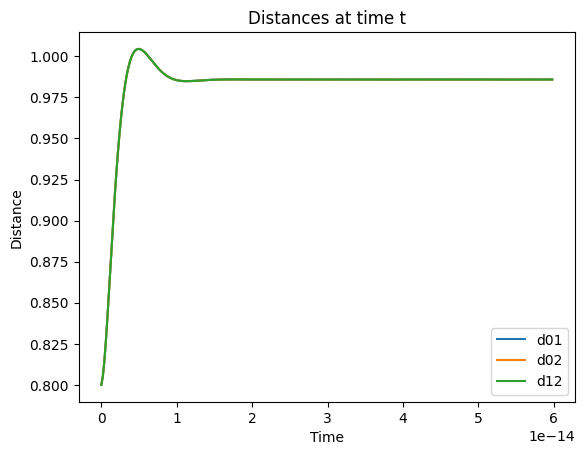

In [15]:
np_distance01 = np.array(distance01)
np_distance02 = np.array(distance02)
np_distance12 = np.array(distance12)

all_traces = np.stack((times,np_distance01[1:],np_distance02[1:],np_distance12[1:]))
np.save('h3_full_10shots_8dt',all_traces)

plt.plot(times,np_distance01[:-1],label = 'd01')
plt.plot(times,np_distance02[:-1],label = 'd02')
plt.plot(times,np_distance12[:-1],label = 'd12')
plt.title('Distances at time t')
plt.xlabel('Time')
plt.ylabel('Distance')
plt.legend()
plt.show()